In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
from comparers import ModelComparer
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances,\
                       estimate_feature_interaction_order
from clustering import make_clustering
from tasks.adult import make_task_with_influential_and_uninfluential_modification as make_task
import matplotlib.pyplot as plt
from IPython.display import display
import shap
import warnings
shap.initjs()
warnings.filterwarnings(action='ignore', category=UserWarning)  # xgboost classifiers print lots of warnings

# Setup Task

In [2]:
categorical_features = ['Workclass', 'Education-Num', 'Marital Status', 'Occupation',
                        'Relationship', 'Race', 'Sex', 'Country']

In [4]:
clf_a, clf_b, X, X_display, y, feature_names = make_task()
with open('task.test.pickle', 'wb') as f:
    pickle.dump((clf_a, clf_b, X, X_display, y, feature_names), f, pickle.HIGHEST_PROTOCOL)

[12:05:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "nestimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:05:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:05:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "nestimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above c

In [5]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [6]:
# Do not sample from background data set, use all
masker = shap.maskers.Independent(data=X, max_samples=len(X))

In [7]:
%%time
indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker, algorithm='exact',
                                               explanation_type='indiv', space_type='log_odds')
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, algorithm='exact',
                                                 explanation_type='mclass_diff', space_type='log_odds')
with open('indiv.test.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)
with open('diffclf.test.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

Exact explainer: 978it [28:06,  1.73s/it]                         
Exact explainer: 978it [31:32,  1.95s/it]                         

CPU times: user 2h 43min 42s, sys: 13min 23s, total: 2h 57min 6s
Wall time: 59min 39s


# Traditional SHAP Explanations

In [10]:
with open('task.test.pickle', 'rb') as f:
    clf_a, clf_b, X, X_display, y, feature_names = pickle.load(f)
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [11]:
with open('indiv.test.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

In [12]:
# For binary classification problems only the positive class is interesting
indiv_shap_values = indiv_shap_values[:, :, ['A.True', 'B.True']]

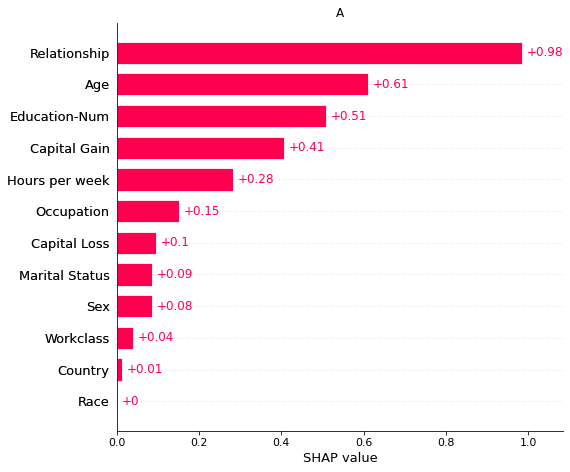

In [13]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'A.True'])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

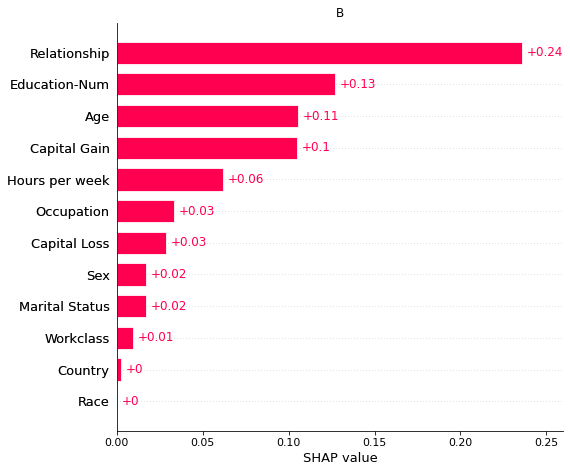

In [14]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, 'B.True'])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [15]:
%%time
node = make_clustering(comparer, indiv_shap_values)

CPU times: user 161 ms, sys: 12.9 ms, total: 174 ms
Wall time: 107 ms


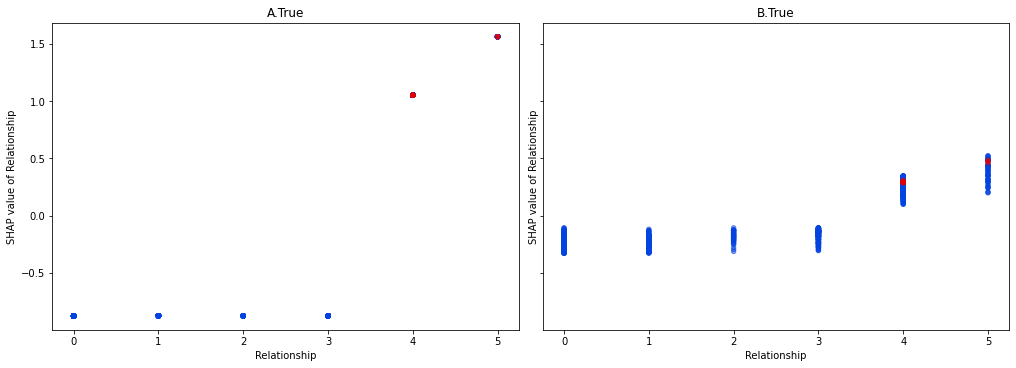

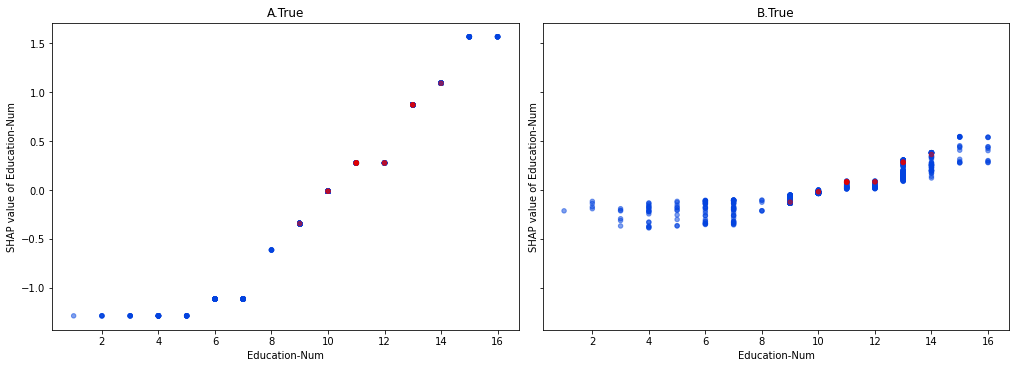

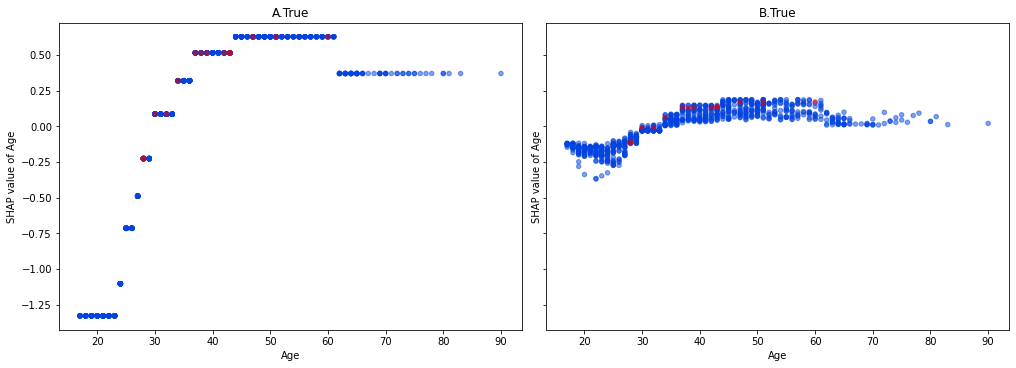

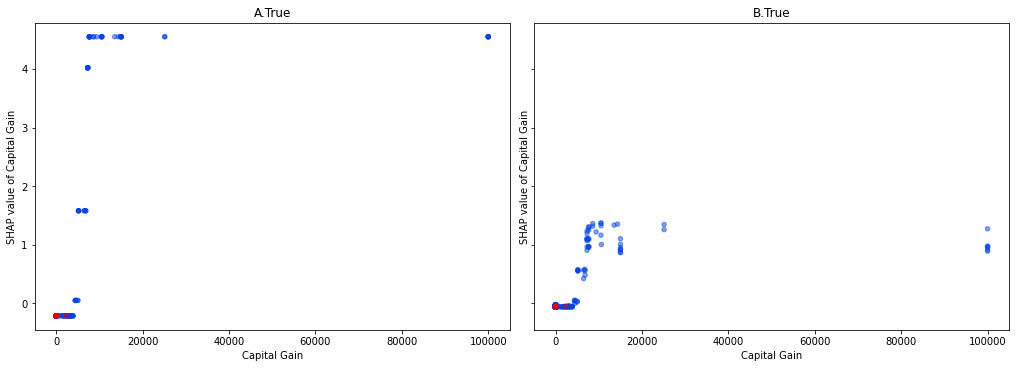

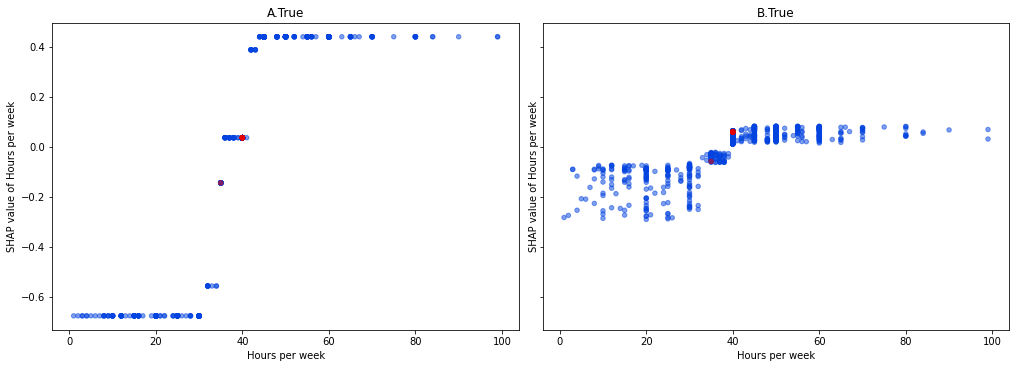

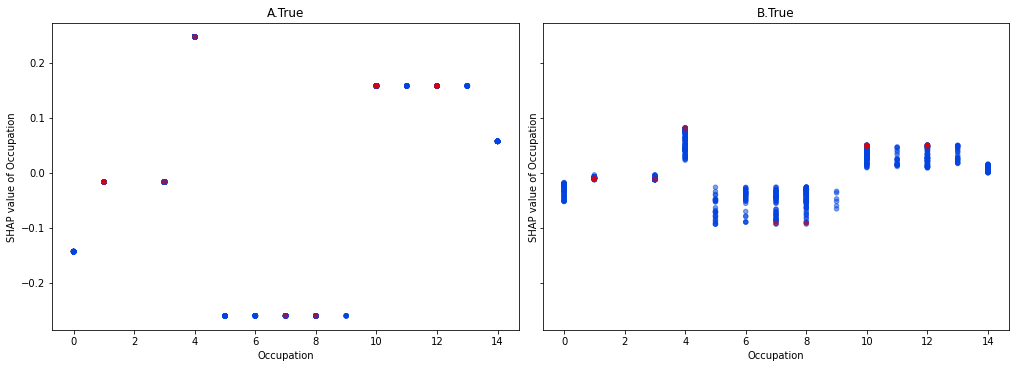

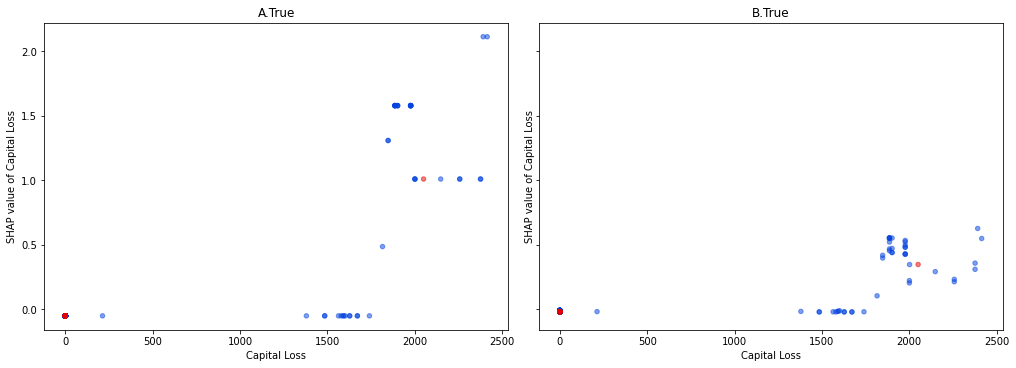

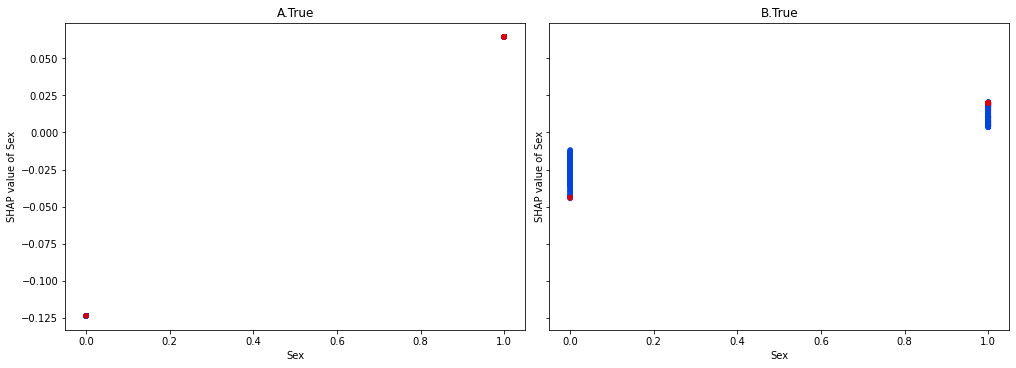

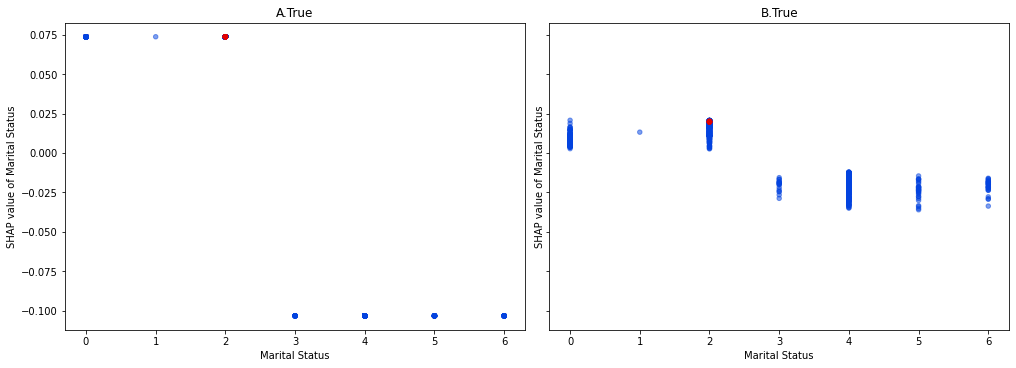

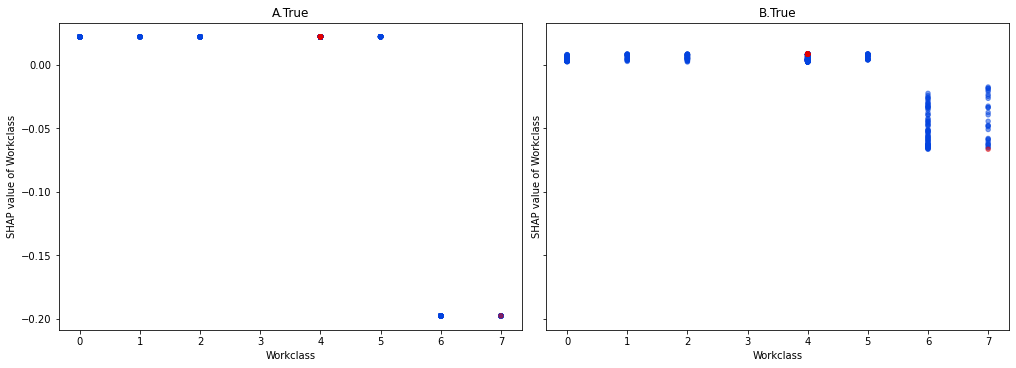

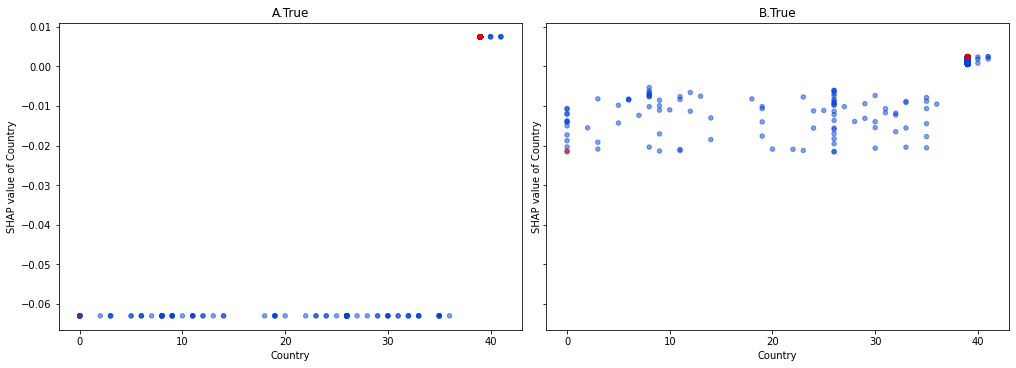

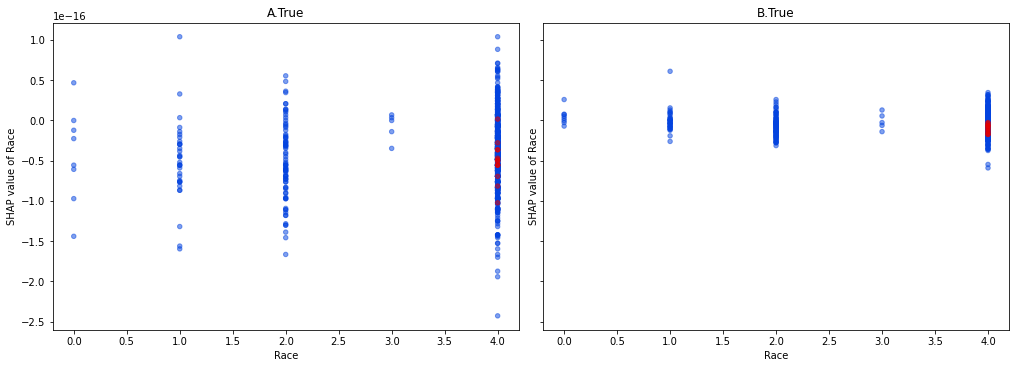

In [16]:
for feature in feature_order:
    node.plot_feature_dependence(feature, alpha=0.5)

# Difference Classifier SHAP Explanations

In [17]:
with open('task.test.pickle', 'rb') as f:
    clf_a, clf_b, X, X_display, y, feature_names = pickle.load(f)
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [18]:
with open('diffclf.test.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

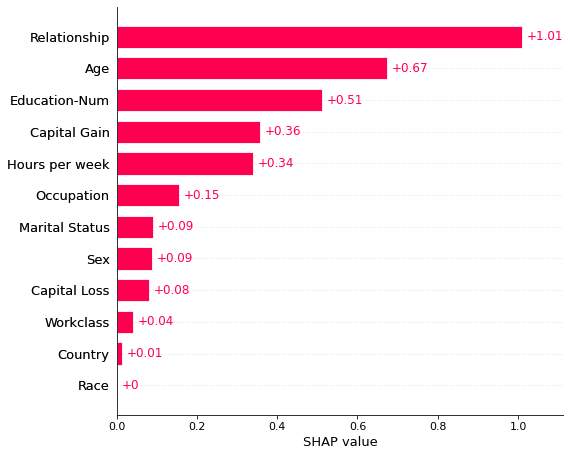

In [19]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

The rounded feature importances are exactly the same.

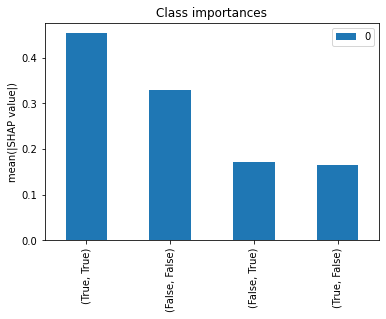

In [20]:
class_order, class_importances = calc_class_order(diffclf_shap_values)
plot_class_importances(class_importances, class_order, diffclf_shap_values.output_names)

## Clustering of Class $(False, True)$ SHAP Values

In [21]:
%%time
node = make_clustering(comparer, diffclf_shap_values, '(False, True)',
                       ['(False, False)', '(False, True)', '(True, True)'],
                       categorical_features=categorical_features)
node.class_counts, node.distance

CPU times: user 58.6 s, sys: 3.39 s, total: 1min 1s
Wall time: 18.1 s


((False, False)    801
 (True, True)      162
 (False, True)      14
 dtype: int64,
 176.87716352316)

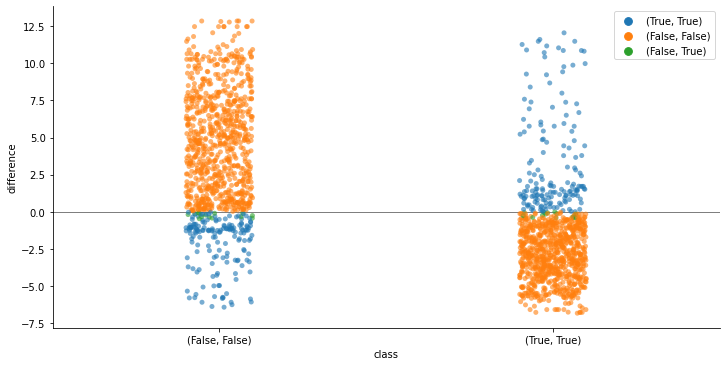

{'(False, False)': '-0.46 to -0.07', '(True, True)': '-0.41 to -0.0'}


In [22]:
node.plot_outcome_differences()

### Node R

In [23]:
node = node.get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(R,
 (False, False)    801
 (True, True)      121
 (False, True)      14
 dtype: int64,
 92.75638954641694)

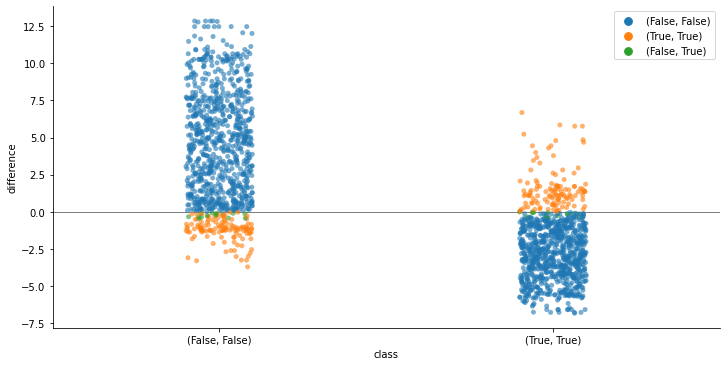

{'(False, False)': '-0.46 to -0.07', '(True, True)': '-0.41 to -0.0'}


In [24]:
node.plot_outcome_differences()

4.0 <= Relationship
Relationship <= 3.0 --> {'(False, False)': 14}


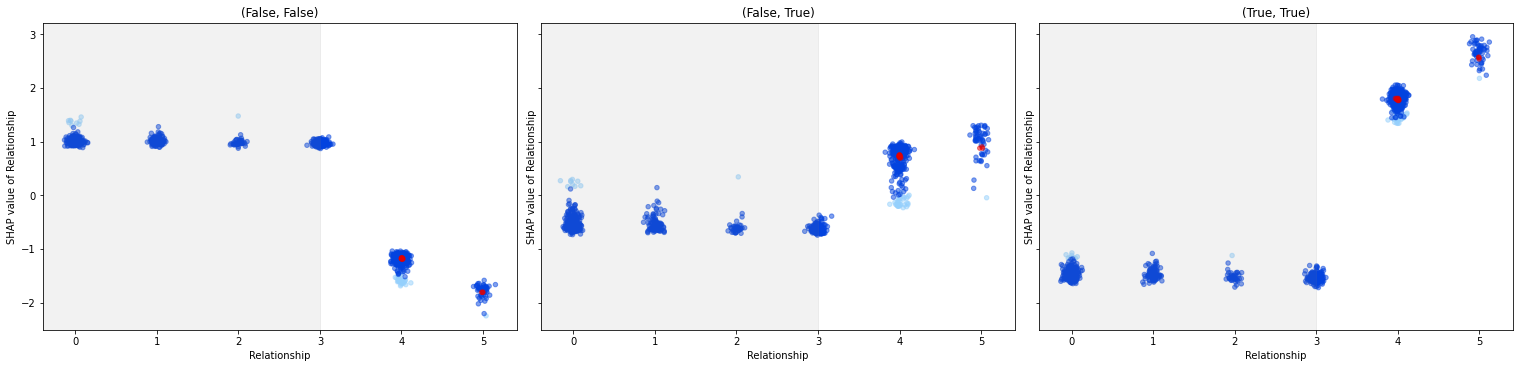

28.0 <= Age <= 60.0
Age <= 26.0 --> {'(False, False)': 14}


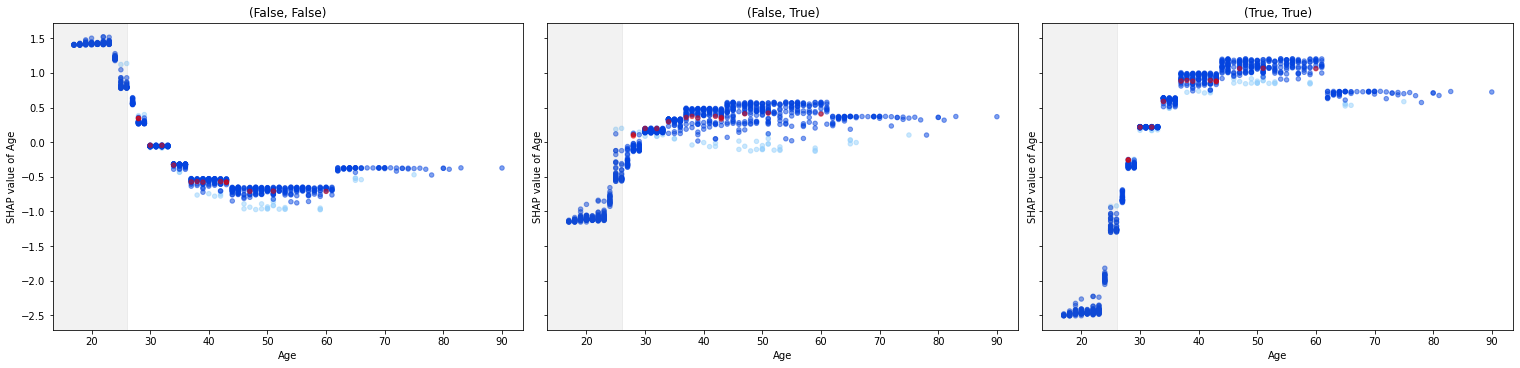

9.0 <= Education-Num <= 14.0
Education-Num <= 8.0 --> {'(False, False)': 14}
Education-Num >= 15.0 --> {'(True, True)': 14}


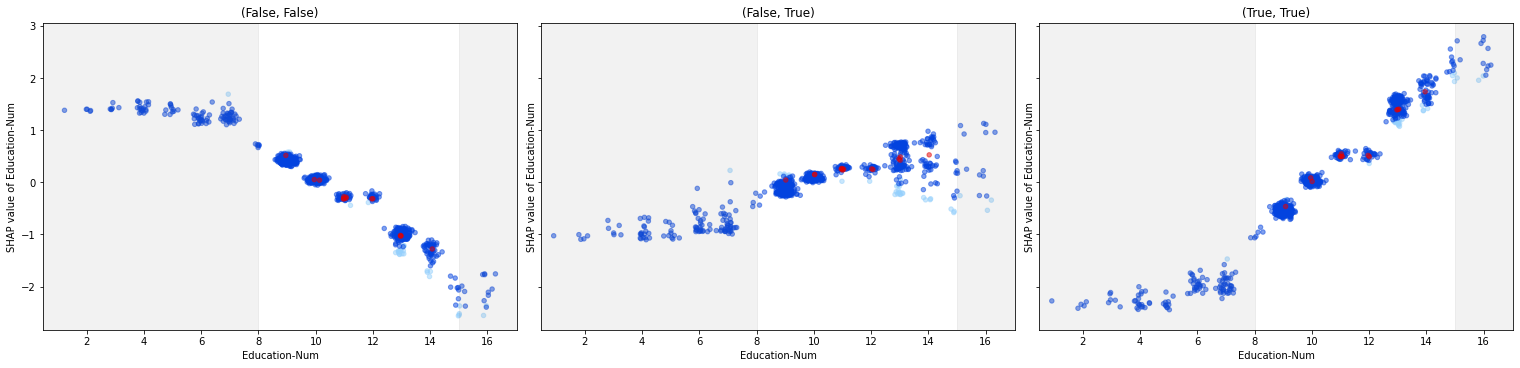

35.0 <= Hours per week <= 40.0
Hours per week <= 33.0 --> {'(False, False)': 14}
Hours per week >= 42.0 --> {'(True, True)': 14}


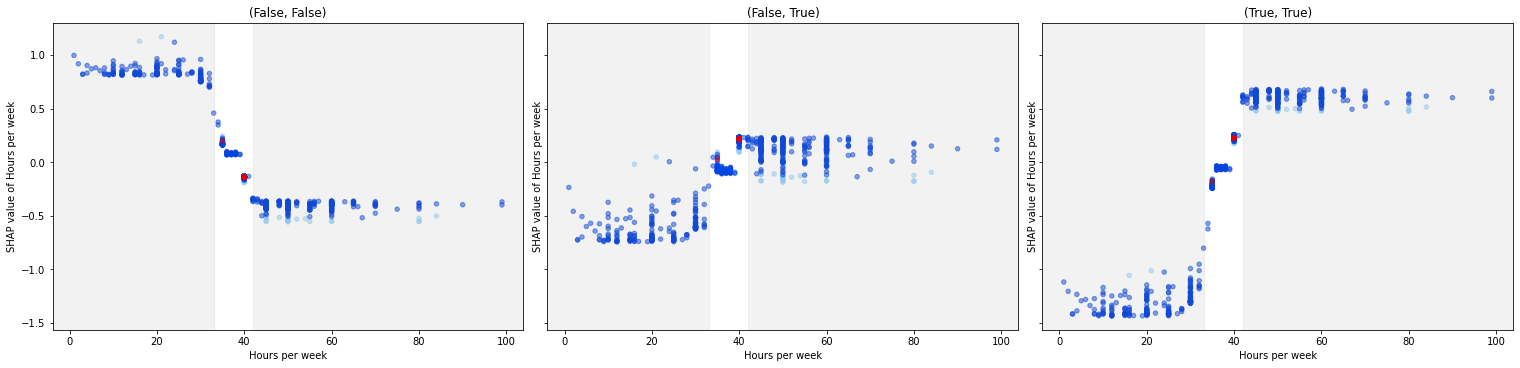

Capital Gain <= 2407.0
Capital Gain >= 5119.0 --> {'(True, True)': 14}


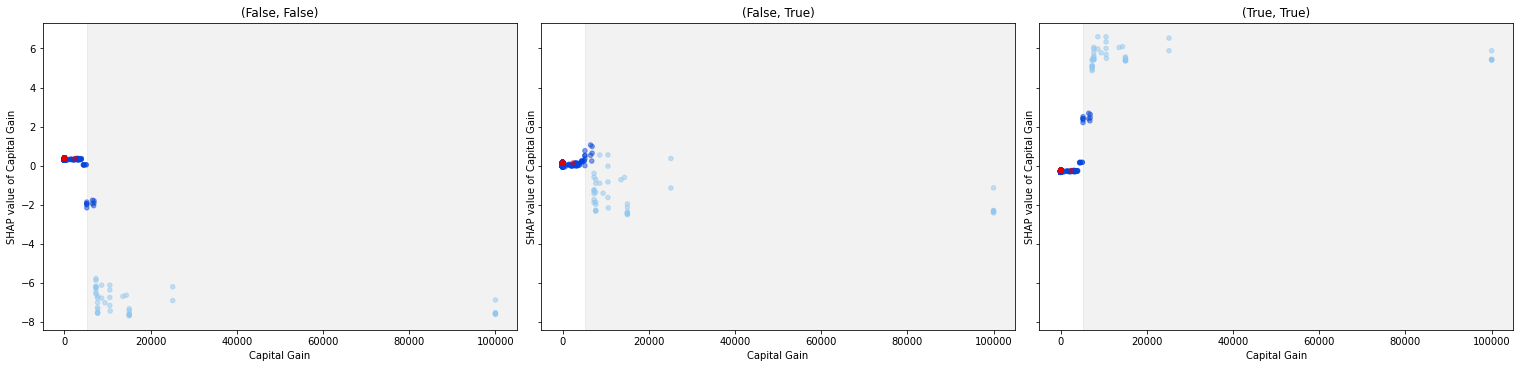

Capital Loss <= 2051.0
Capital Loss >= 2385.0 --> {'(True, True)': 14}


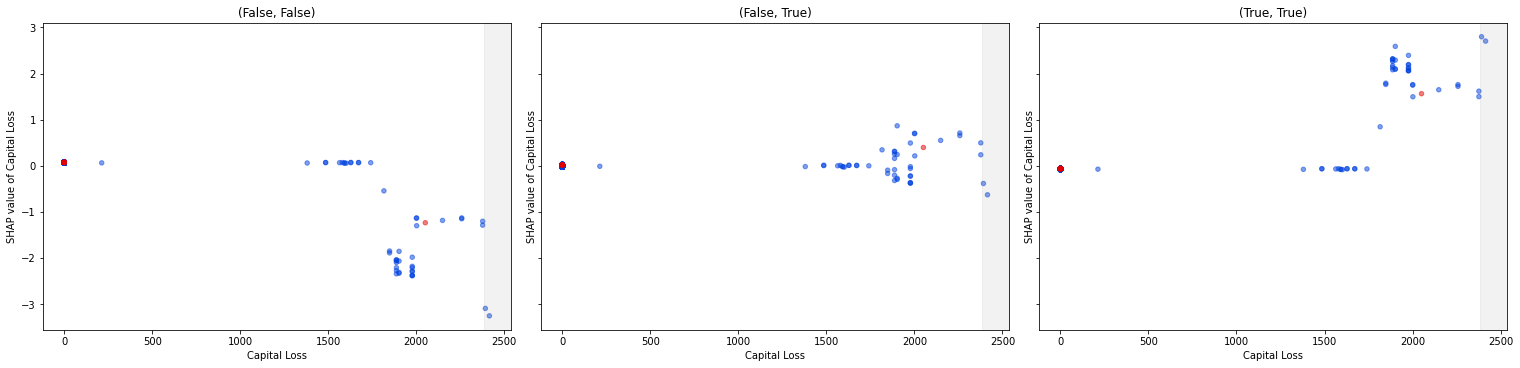

In [26]:
for feature in node.features_with_counterfactuals:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

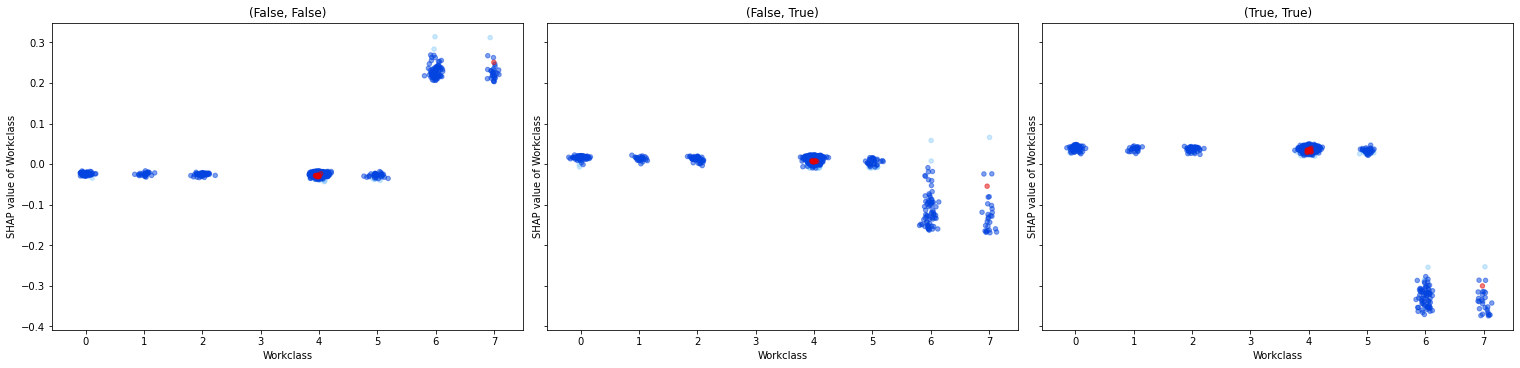

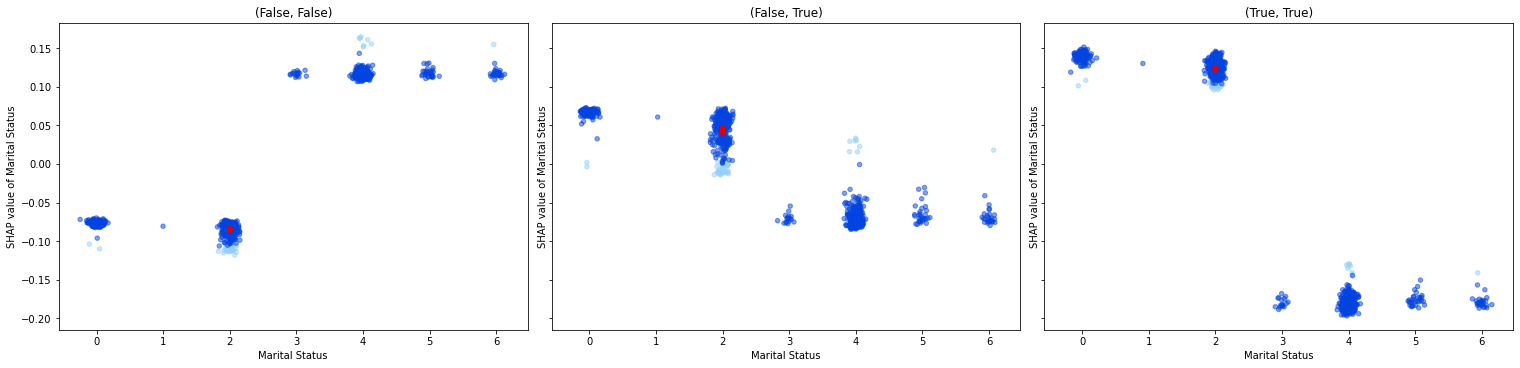

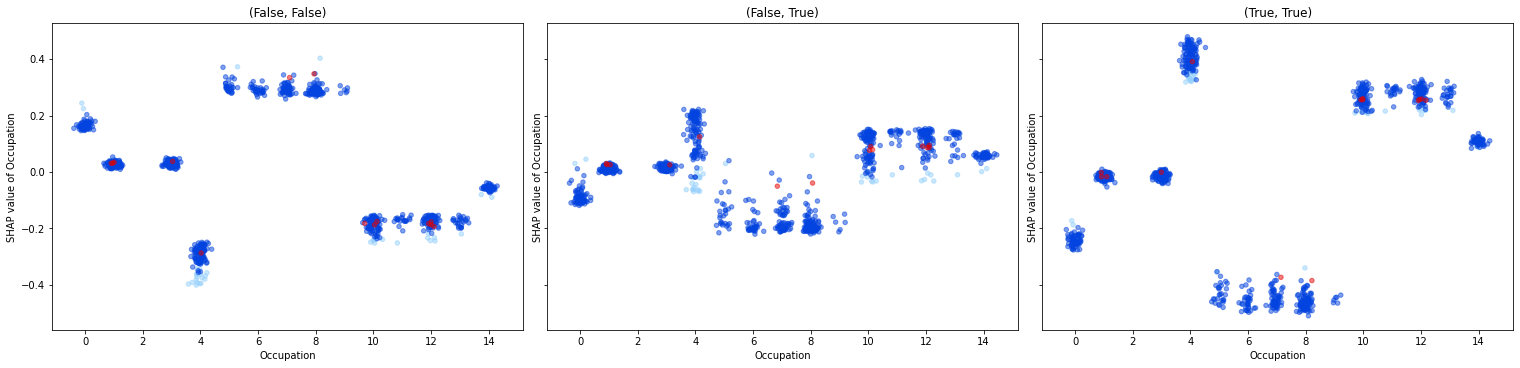

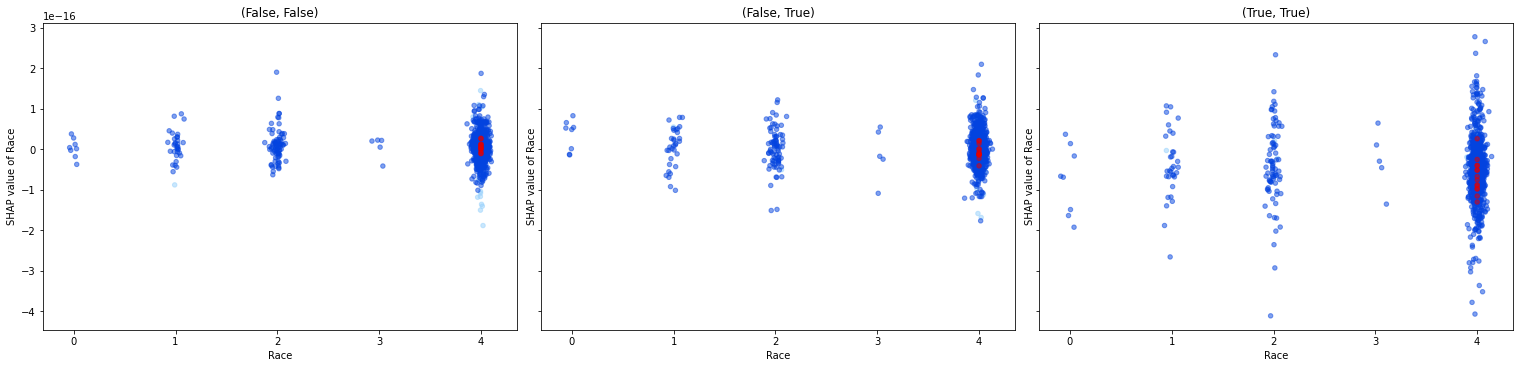

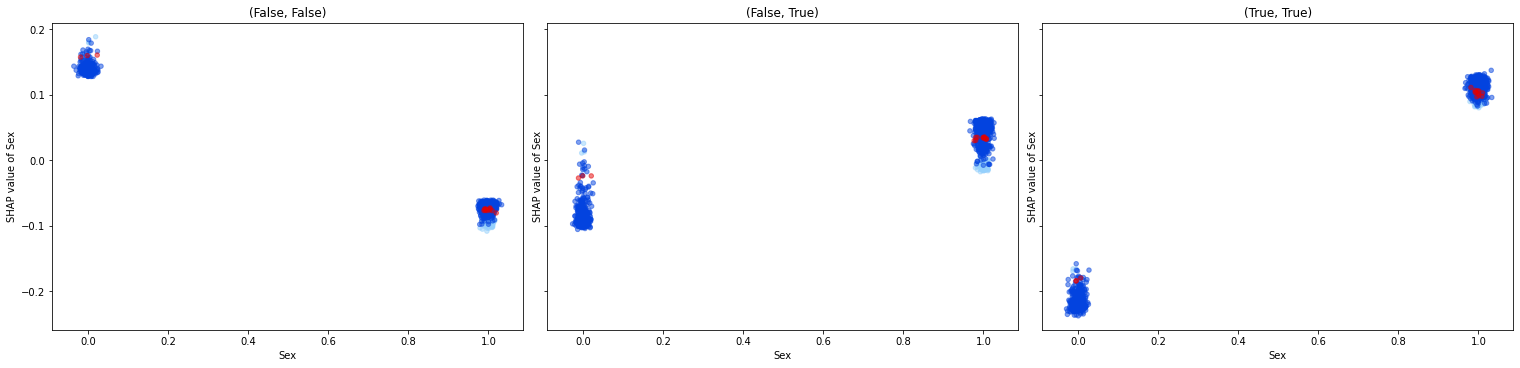

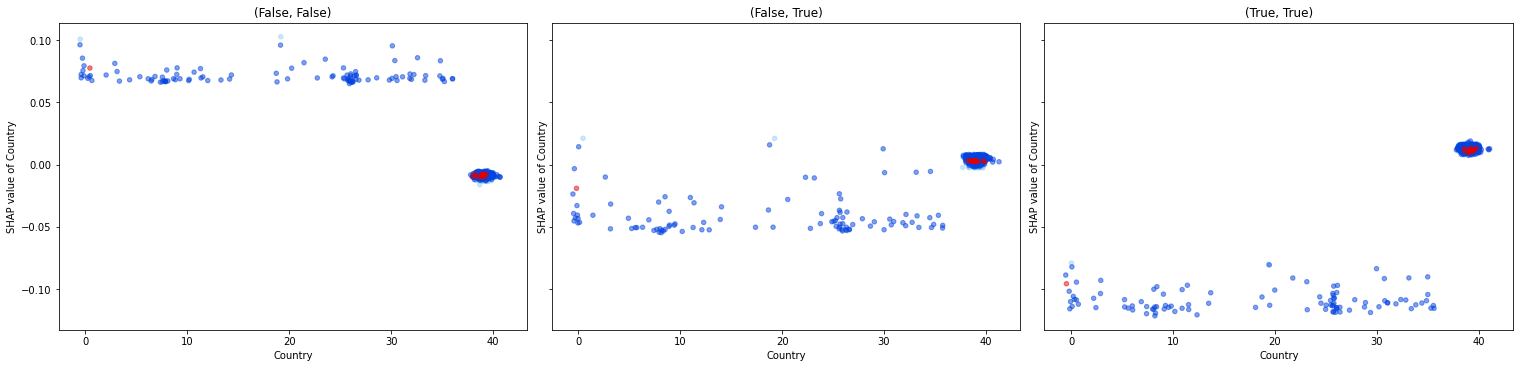

In [27]:
for feature in node.features_without_counterfactuals:
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

### Node RLLRLRRLR

In [28]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RLLRLRRLR,
 (False, True)    1
 dtype: int64,
 0)

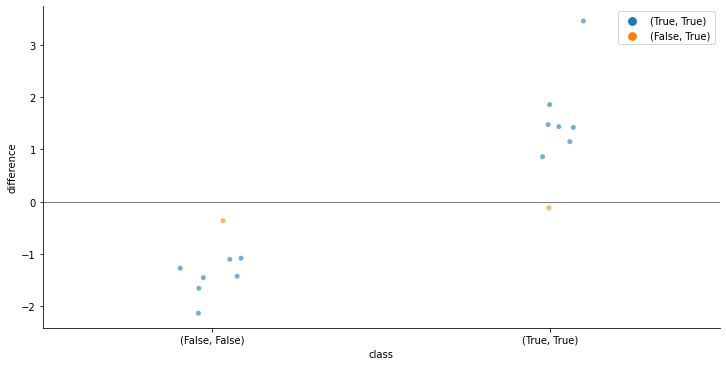

{'(False, False)': '-0.36 to -0.36', '(True, True)': '-0.12 to -0.12'}


In [30]:
ref_node = node.get_parent(2)
ref_node.plot_outcome_differences()

Relationship == 4.0
Relationship <= 3.0 --> {'(False, False)': 1}
Relationship >= 5.0 --> {'(True, True)': 1}


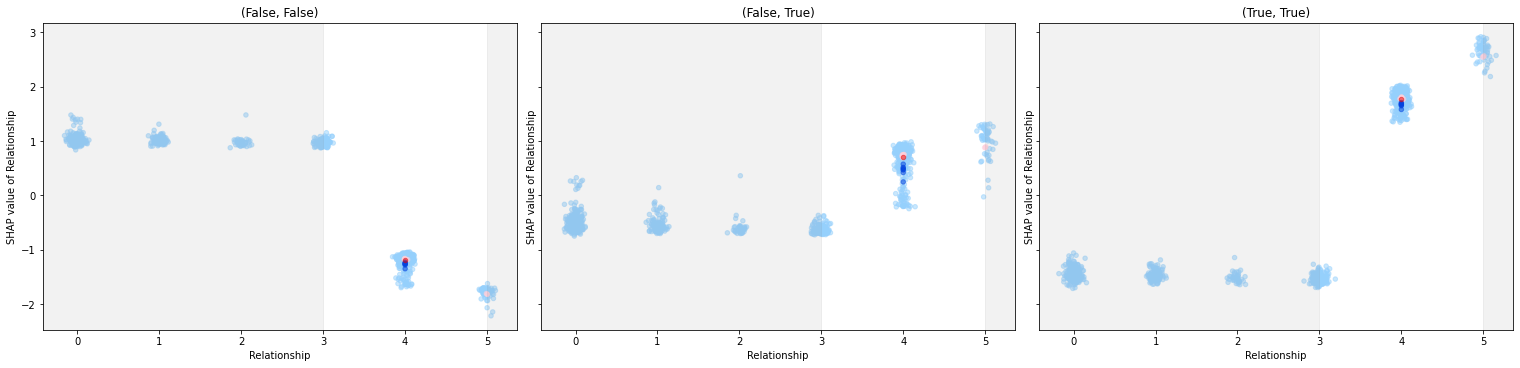

Capital Loss == 2051.0
Capital Loss <= 1978.0 --> {'(True, True)': 1}
Capital Loss >= 2385.0 --> {'(True, True)': 1}


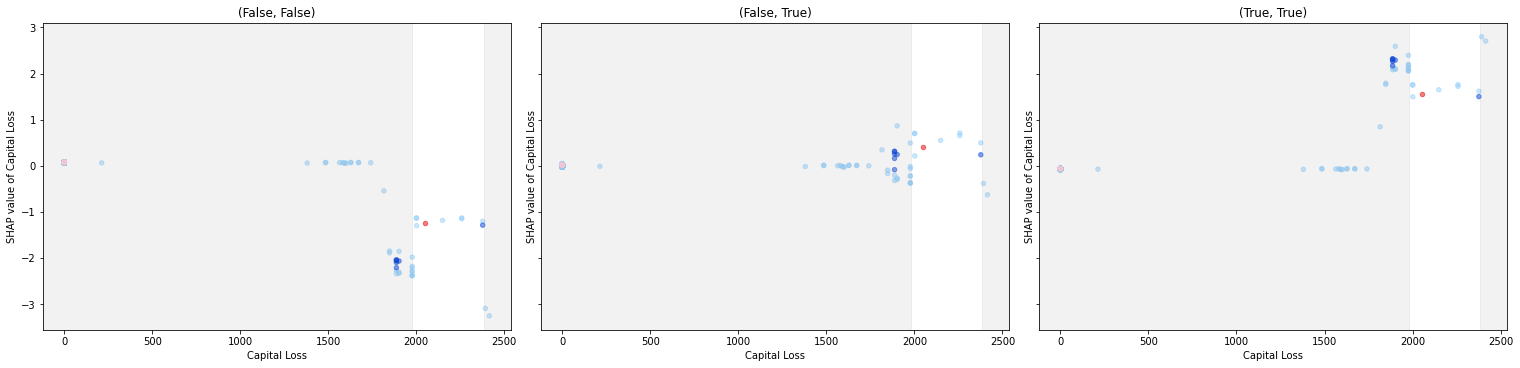

Age == 39.0
Age <= 33.0 --> {'(False, False)': 1}
Age >= 44.0 --> {'(True, True)': 1}


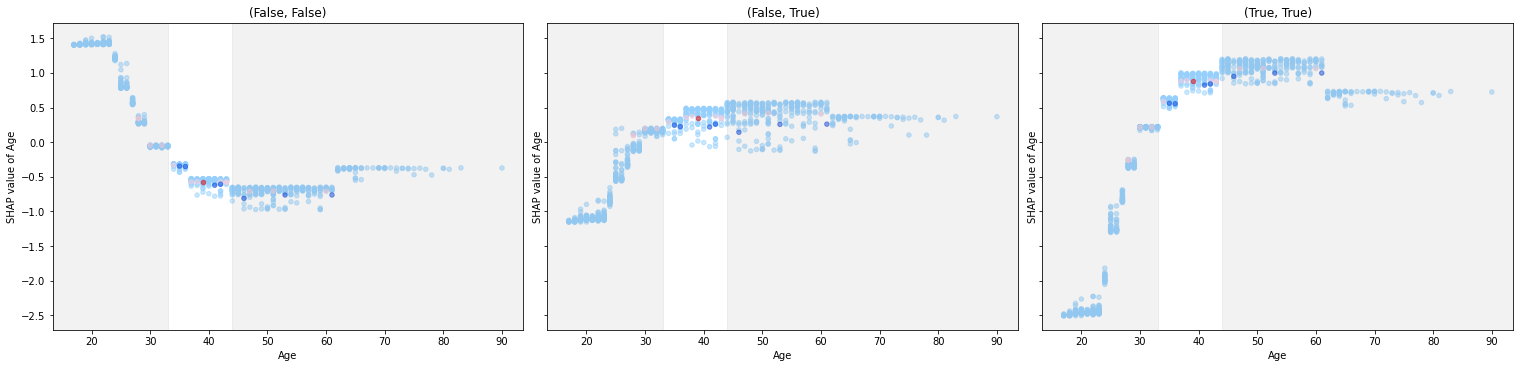

Education-Num == 9.0
Education-Num <= 8.0 --> {'(False, False)': 1}
Education-Num >= 10.0 --> {'(True, True)': 1}


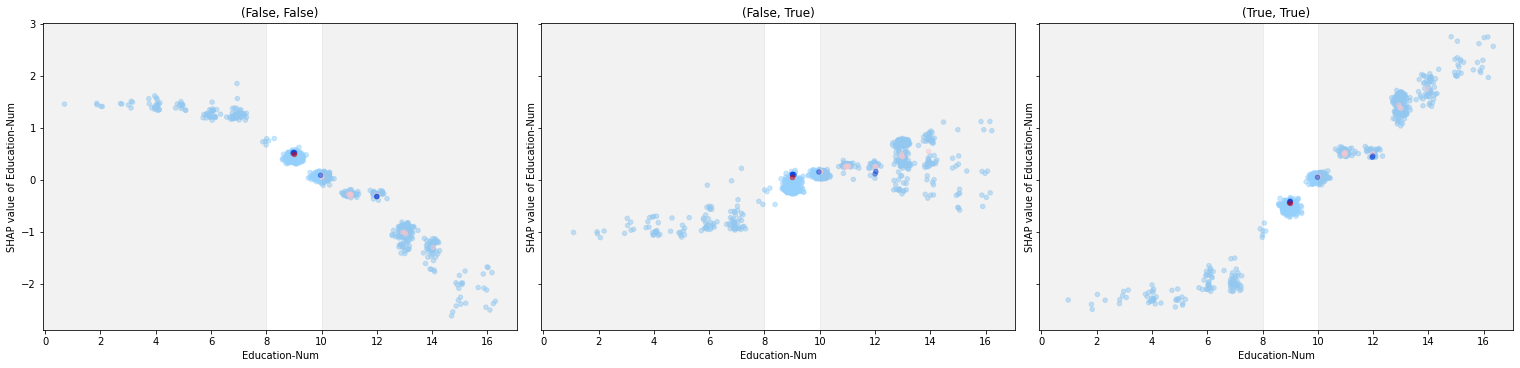

Capital Gain == 0.0
Capital Gain >= 4244.0 --> {'(True, True)': 1}


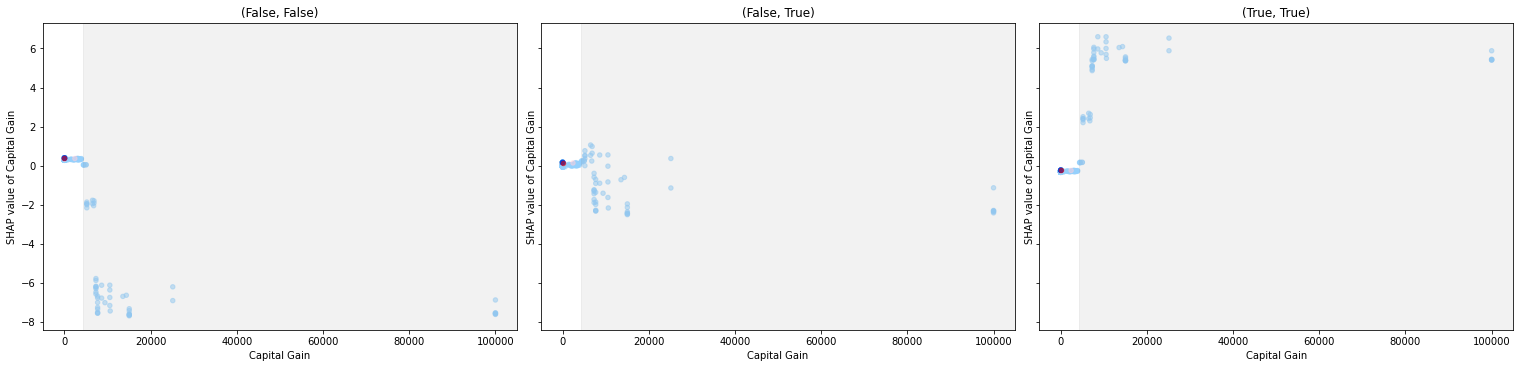

Occupation == 7.0
Occupation <= 4.0 --> {'(True, True)': 1}
Occupation >= 10.0 --> {'(True, True)': 1}


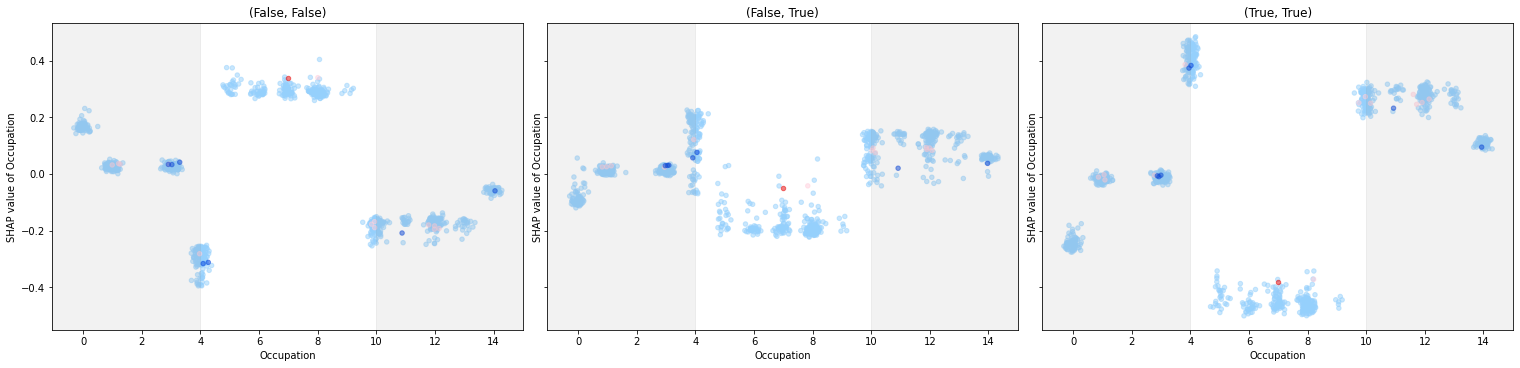

Hours per week == 40.0
Hours per week <= 39.0 --> {'(False, False)': 1}
Hours per week >= 42.0 --> {'(True, True)': 1}


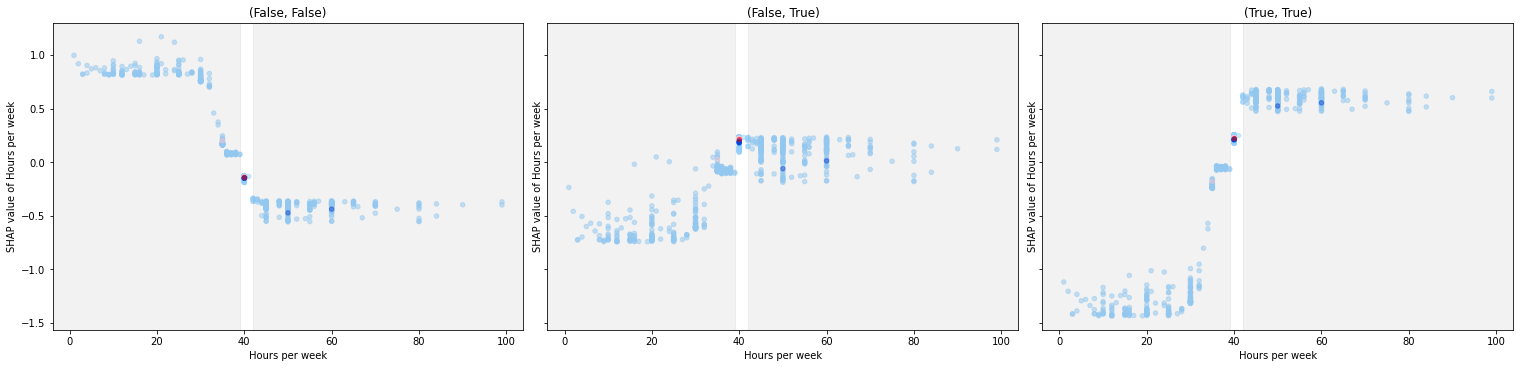

In [32]:
for feature in node.features_with_counterfactuals[:]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=ref_node, alpha=0.5)

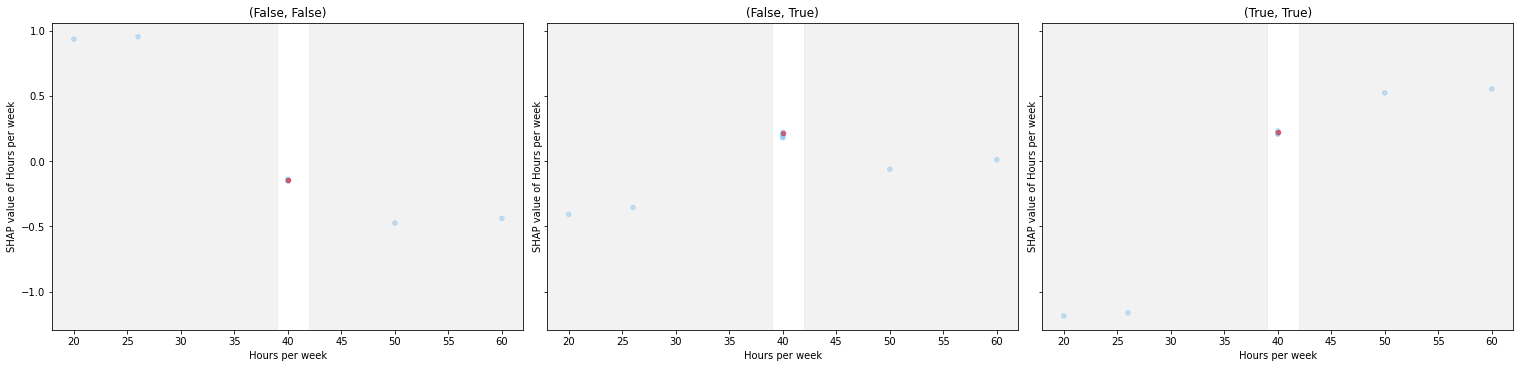

In [33]:
node.get_parent(4).plot_feature_dependence('Hours per week', focus=node, alpha=0.5)

### Node RRRRR

In [34]:
node = node.root.get('RR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRRRR,
 (False, False)    216
 (True, True)       89
 (False, True)      13
 dtype: int64,
 24.345753116580077)

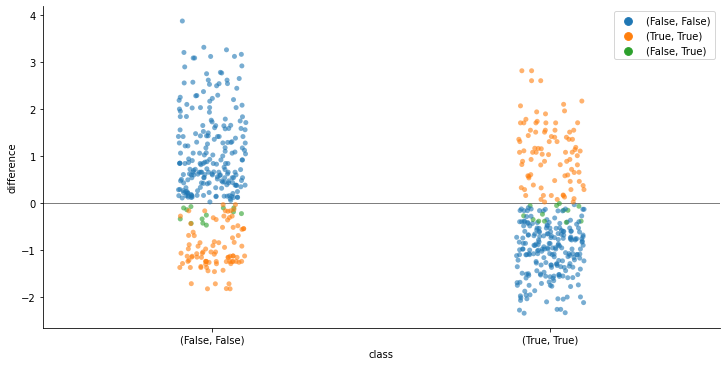

{'(False, False)': '-0.46 to -0.07', '(True, True)': '-0.41 to -0.0'}


In [35]:
node.plot_outcome_differences()

4.0 <= Relationship
Relationship <= 3.0 --> {'(False, False)': 13}


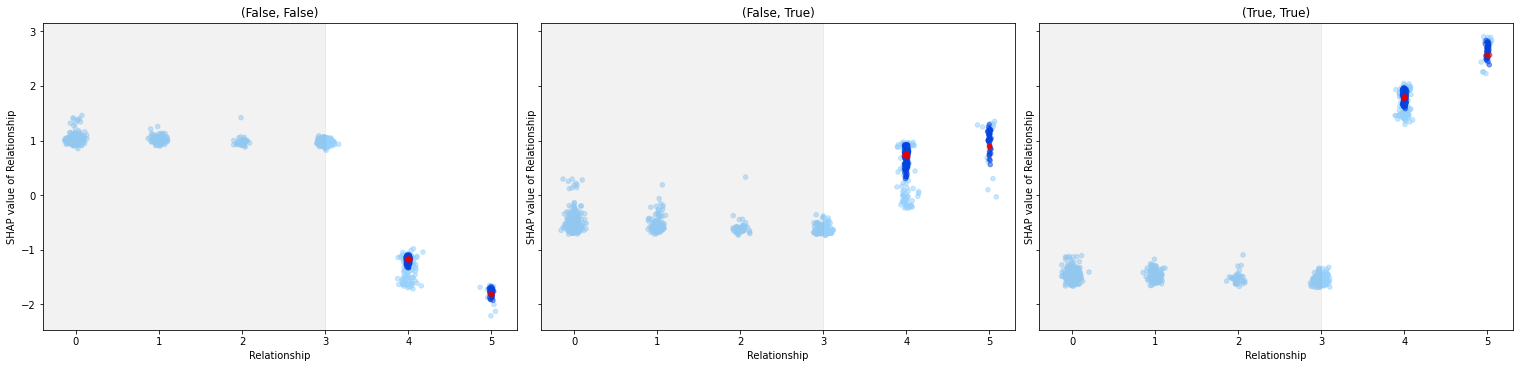

28.0 <= Age <= 60.0
Age <= 26.0 --> {'(False, False)': 13}


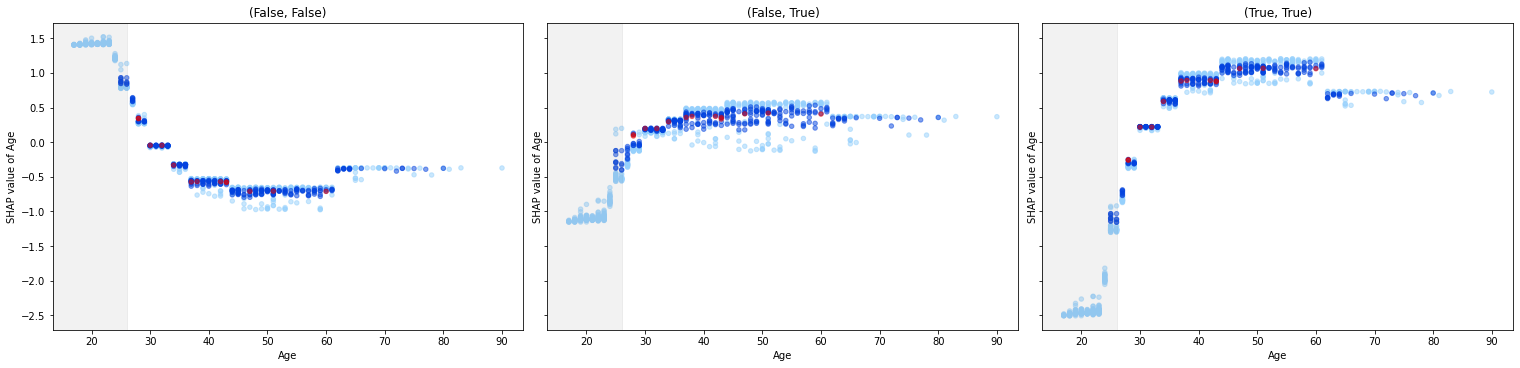

10.0 <= Education-Num <= 14.0
Education-Num <= 9.0 --> {'(False, False)': 13}
Education-Num >= 15.0 --> {'(True, True)': 13}


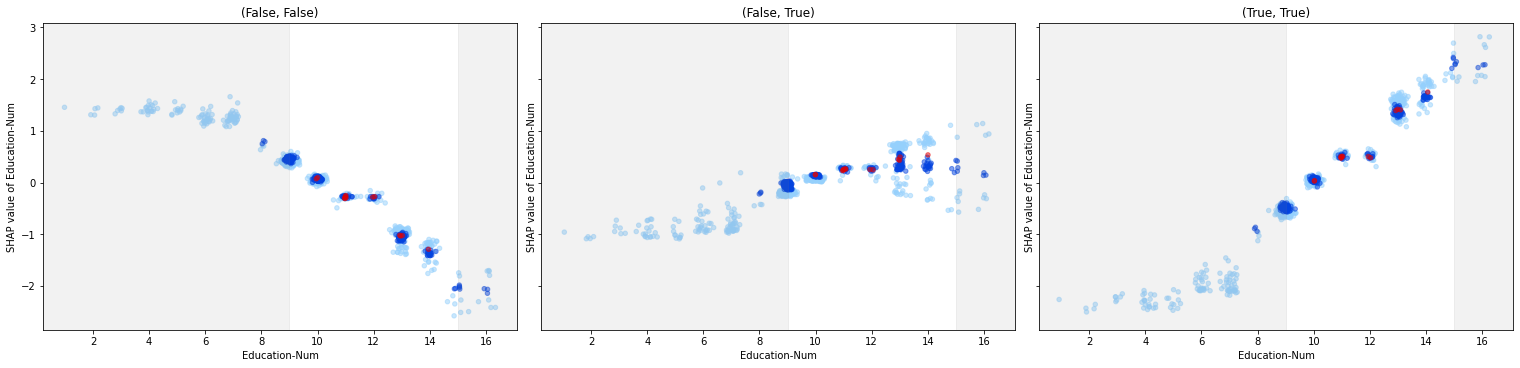

35.0 <= Hours per week <= 40.0
Hours per week <= 33.0 --> {'(False, False)': 13}
Hours per week >= 42.0 --> {'(True, True)': 13}


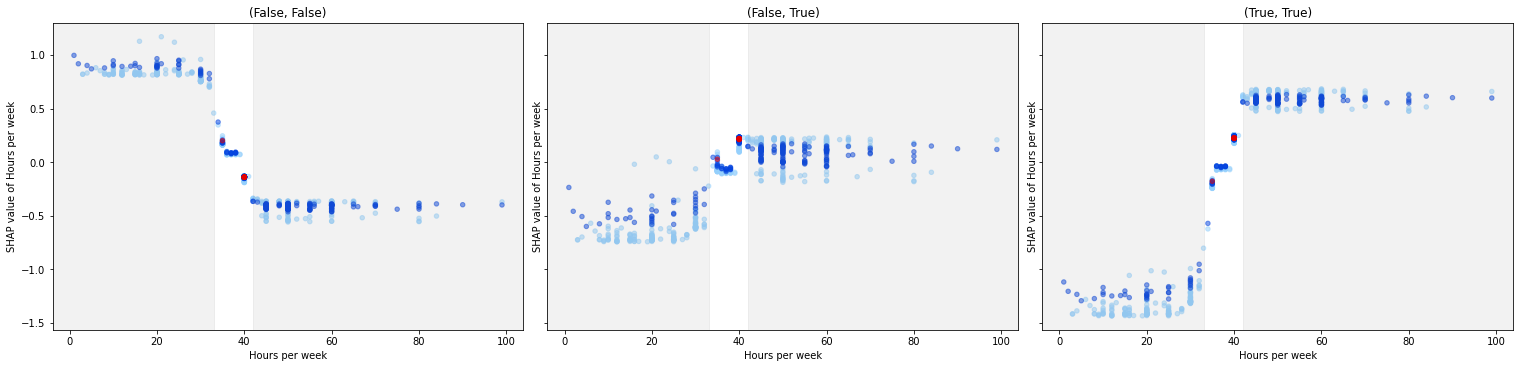

Capital Gain <= 2407.0
Capital Gain >= 5119.0 --> {'(True, True)': 13}


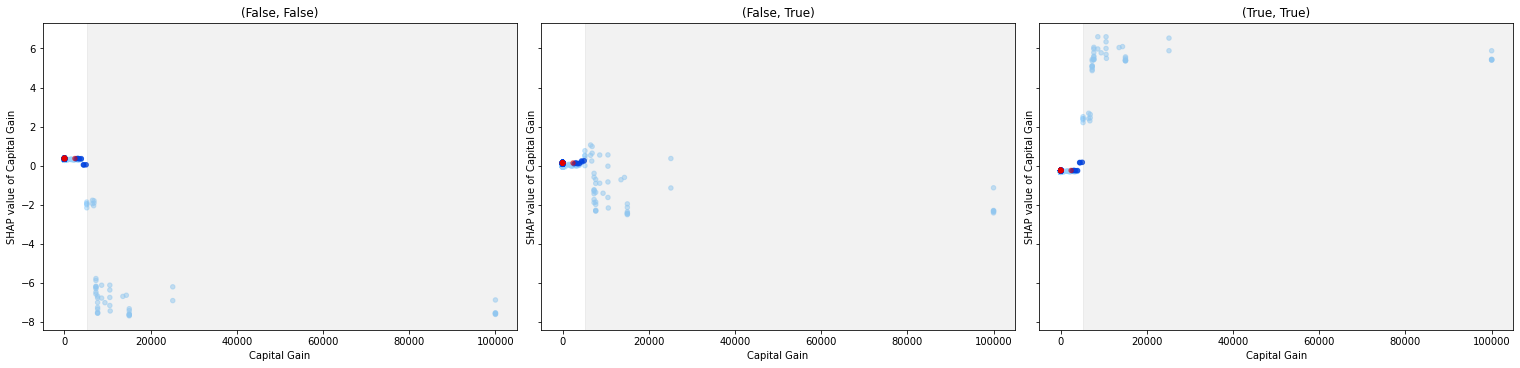

Capital Loss == 0.0
Capital Loss >= 1748.0 --> {'(True, True)': 13}


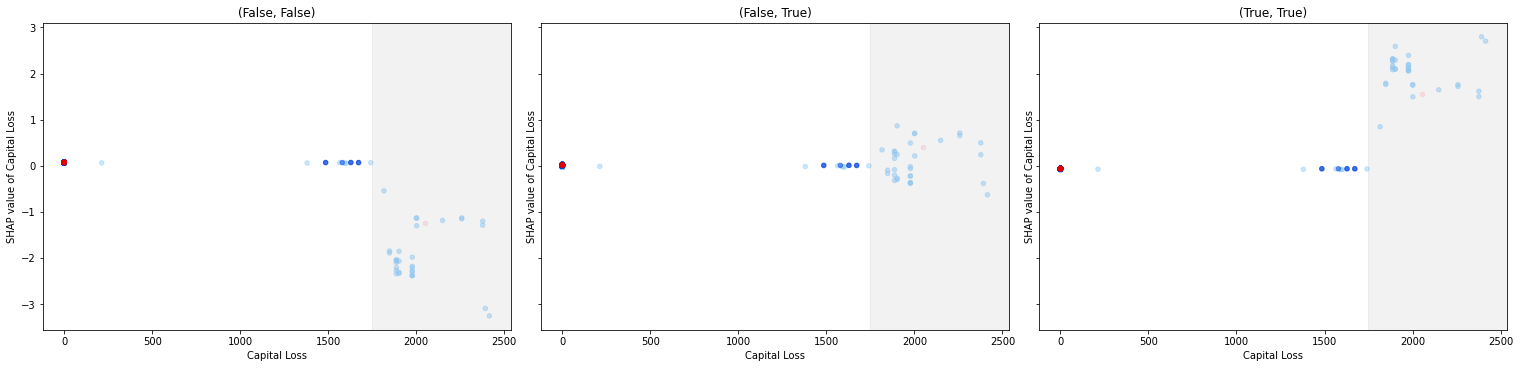

In [37]:
for feature in node.features_with_counterfactuals[:]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

### Node RRRRRL

In [40]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRRRRL,
 (True, True)      71
 (False, False)     7
 (False, True)      4
 dtype: int64,
 10.282445701967044)

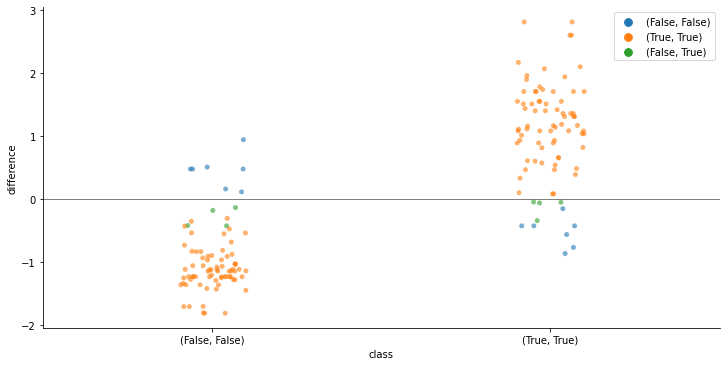

{'(False, False)': '-0.43 to -0.14', '(True, True)': '-0.34 to -0.05'}


In [41]:
node.plot_outcome_differences()

- Education-Num now local differences for 13-14

4.0 <= Relationship
Relationship <= 3.0 --> {'(False, False)': 4}


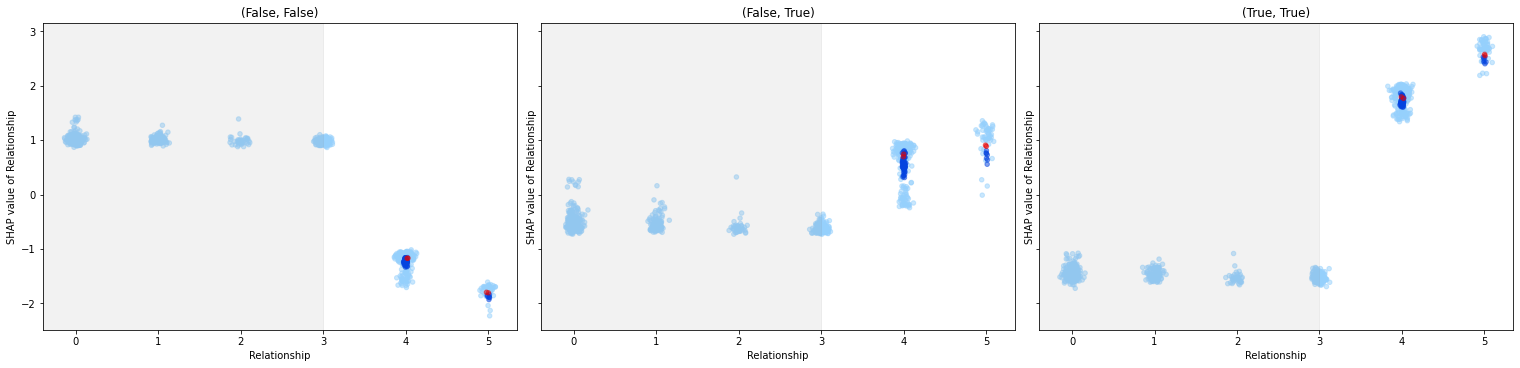

13.0 <= Education-Num <= 14.0
Education-Num <= 12.0 --> {'(False, False)': 4}
Education-Num >= 15.0 --> {'(True, True)': 4}


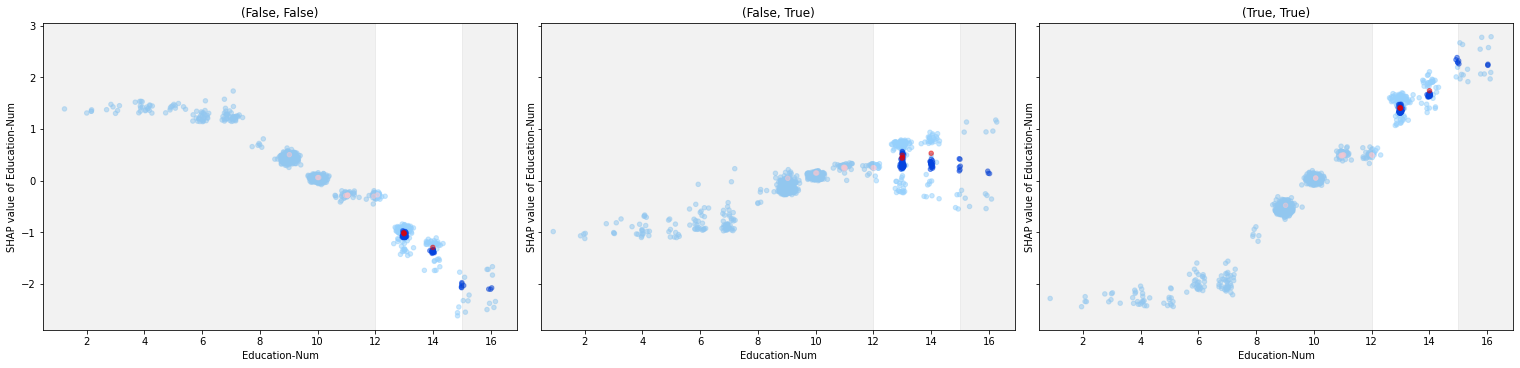

28.0 <= Age <= 32.0
Age <= 26.0 --> {'(False, False)': 4}
Age >= 34.0 --> {'(True, True)': 4}


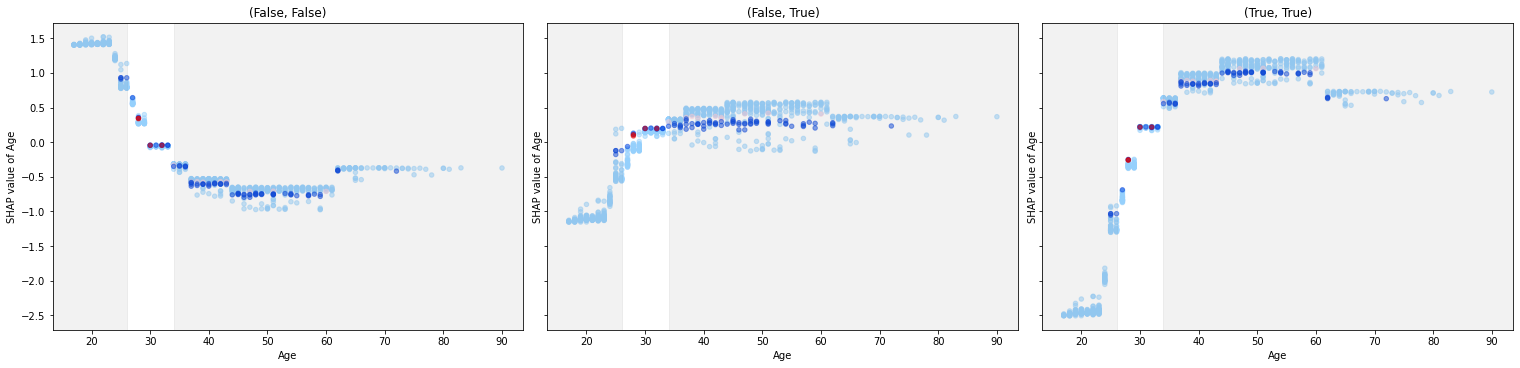

Capital Gain == 0.0
Capital Gain >= 4244.0 --> {'(True, True)': 4}


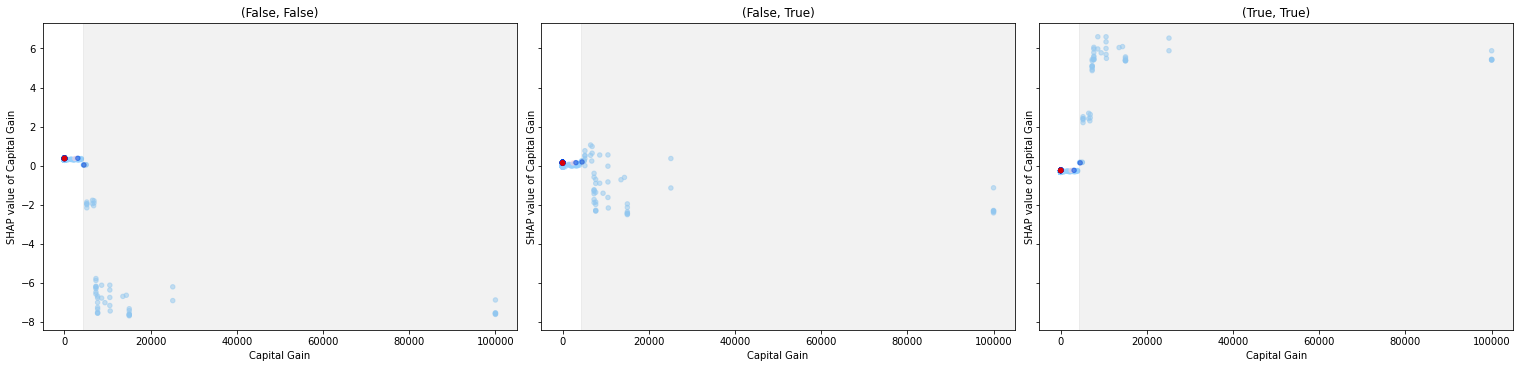

35.0 <= Hours per week <= 40.0
Hours per week <= 33.0 --> {'(False, False)': 4}
Hours per week >= 42.0 --> {'(True, True)': 4}


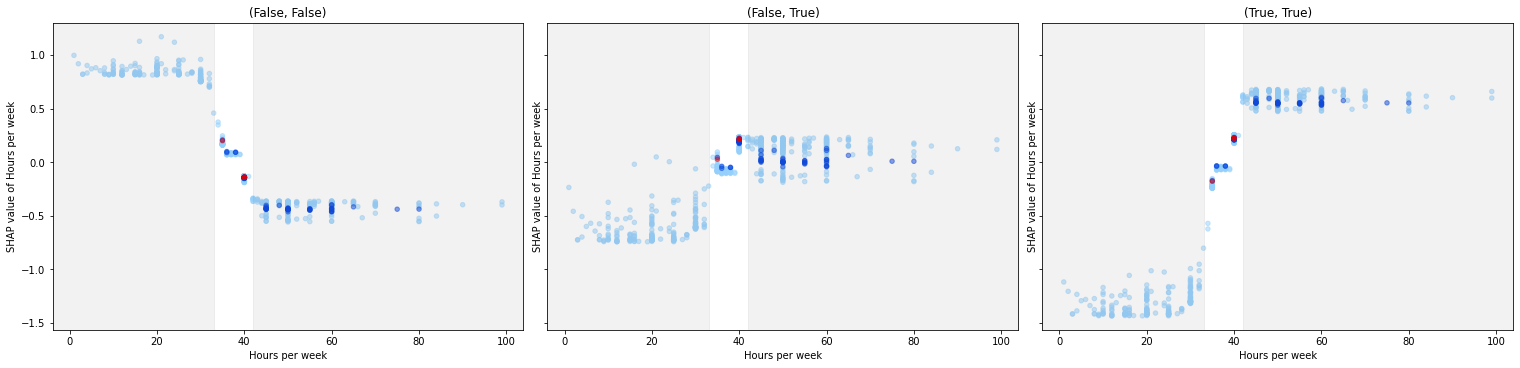

Capital Loss == 0.0
Capital Loss >= 1748.0 --> {'(True, True)': 4}


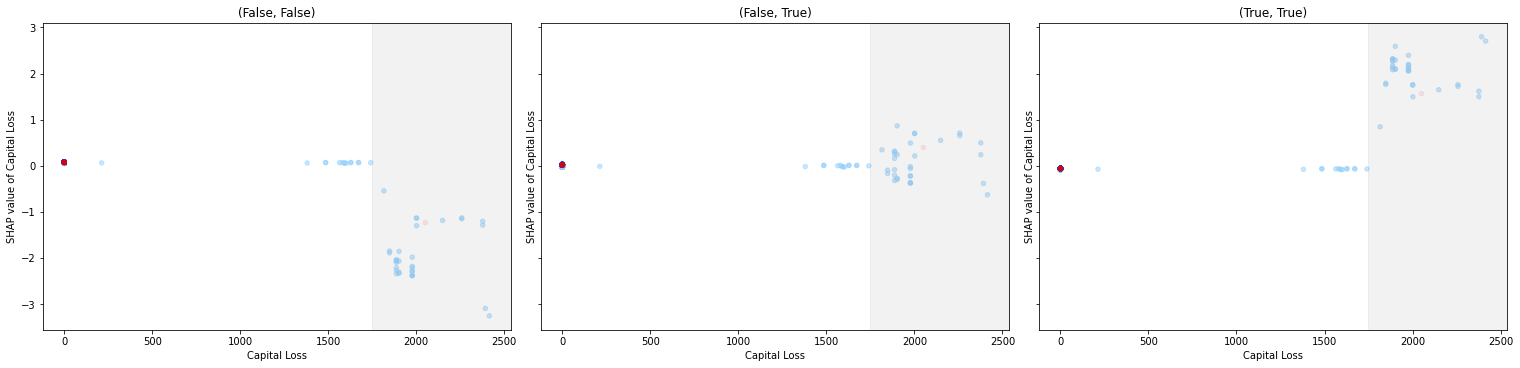

In [42]:
for feature in node.features_with_counterfactuals[:]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

### Node RRRRRLLRRR

In [43]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRRRRLLRRR,
 (False, True)    2
 dtype: int64,
 0.1890673496520596)

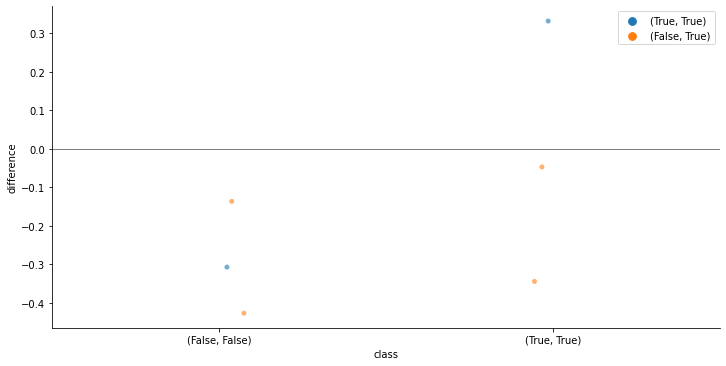

{'(False, False)': '-0.43 to -0.14', '(True, True)': '-0.34 to -0.05'}


In [44]:
ref_node = node.parent
ref_node.plot_outcome_differences()

- Hours per week range where differences are likely is narrow (40-41), supported by the reference group which is very similar in terms of other features but has a higher Hours per week value (45)

In [45]:
ref_node.shap_values[:, 'Hours per week'].data

array([45., 40., 40.])

Relationship == 4.0
Relationship <= 3.0 --> {'(False, False)': 2}
Relationship >= 5.0 --> {'(True, True)': 2}


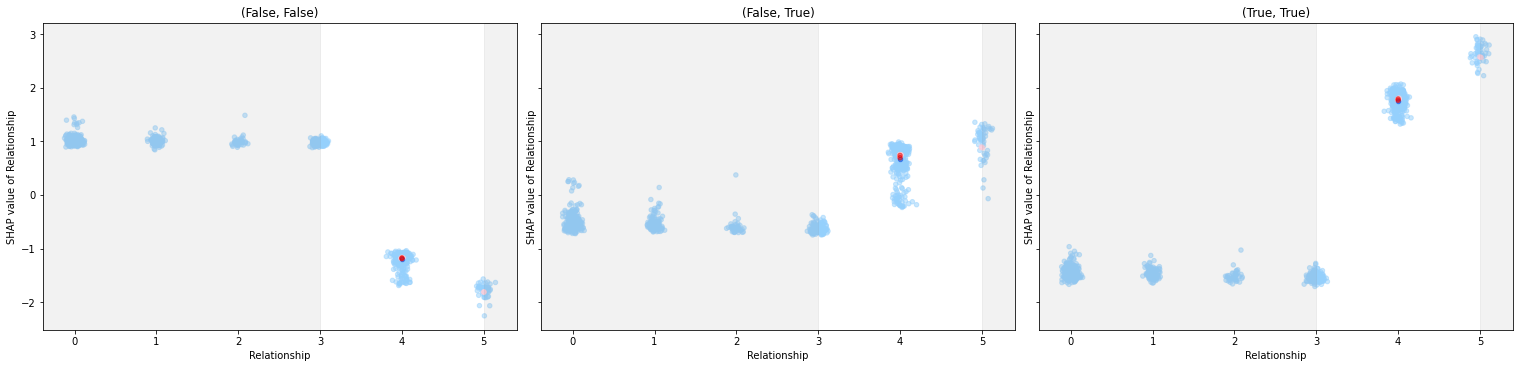

13.0 <= Education-Num <= 14.0
Education-Num <= 12.0 --> {'(False, False)': 2}
Education-Num >= 15.0 --> {'(True, True)': 2}


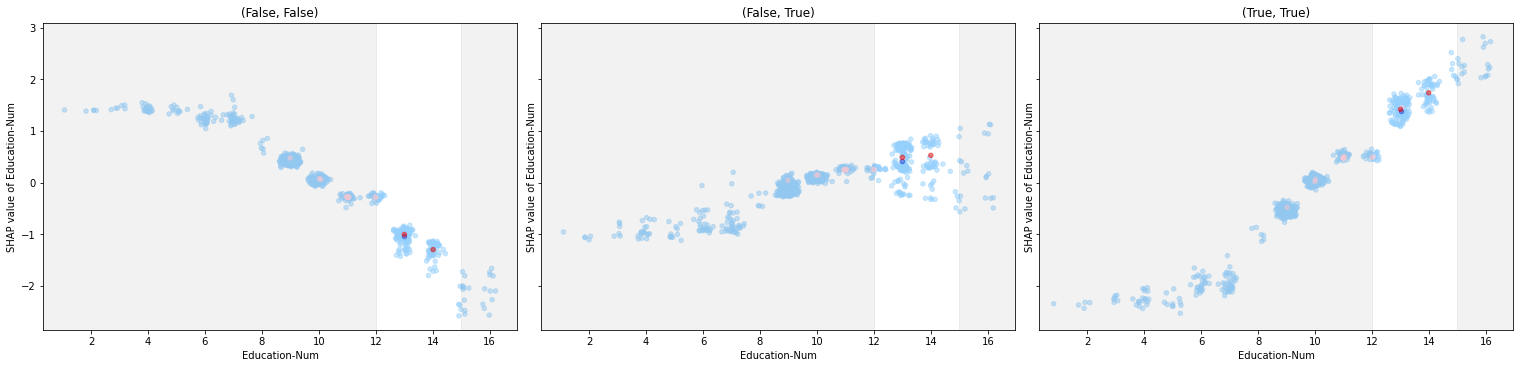

Capital Gain == 0.0
Capital Gain >= 4244.0 --> {'(True, True)': 2}


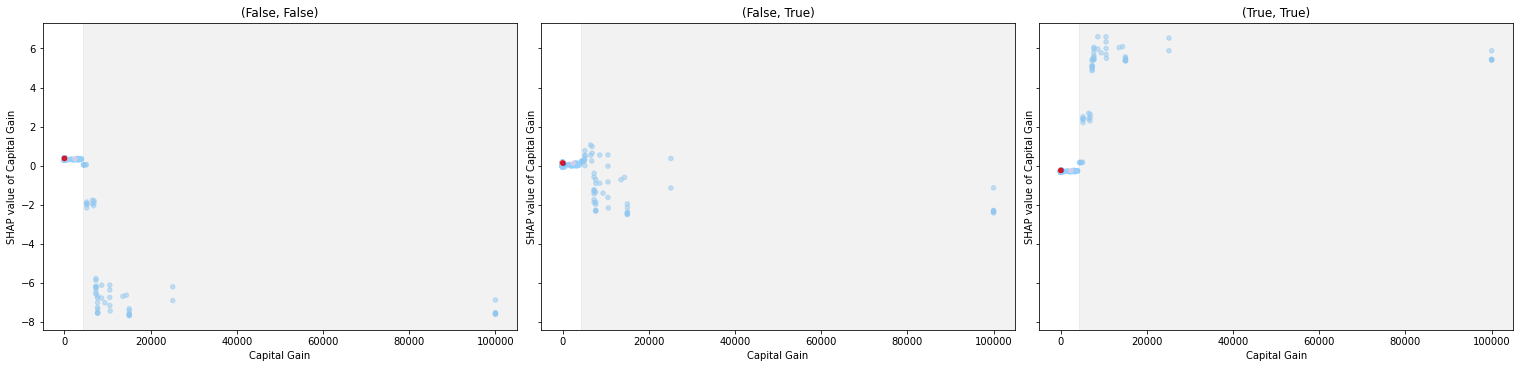

Age == 28.0
Age <= 26.0 --> {'(False, False)': 2}
Age >= 30.0 --> {'(True, True)': 2}


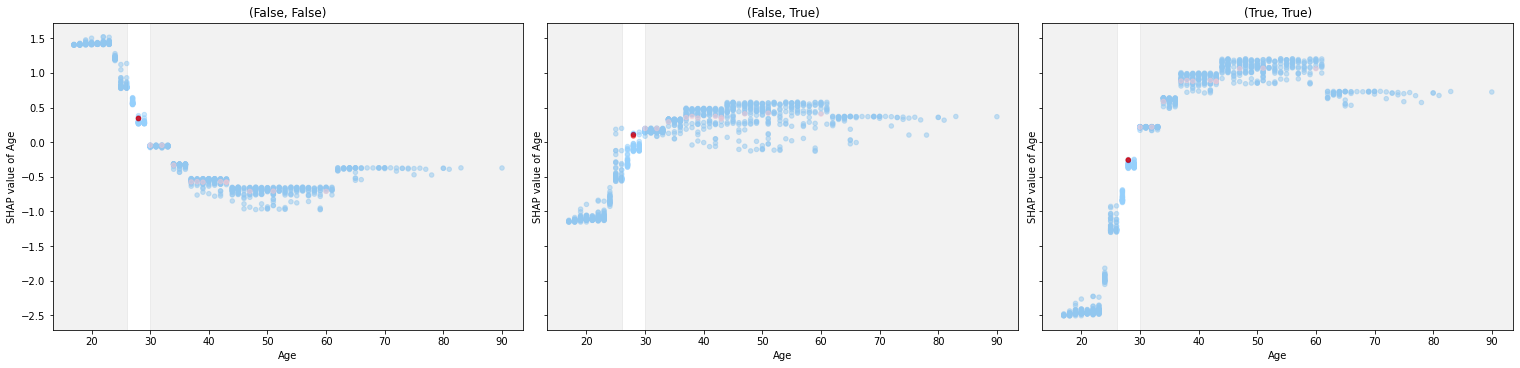

Occupation == 10.0
Occupation <= 9.0 --> {'(False, False)': 2}


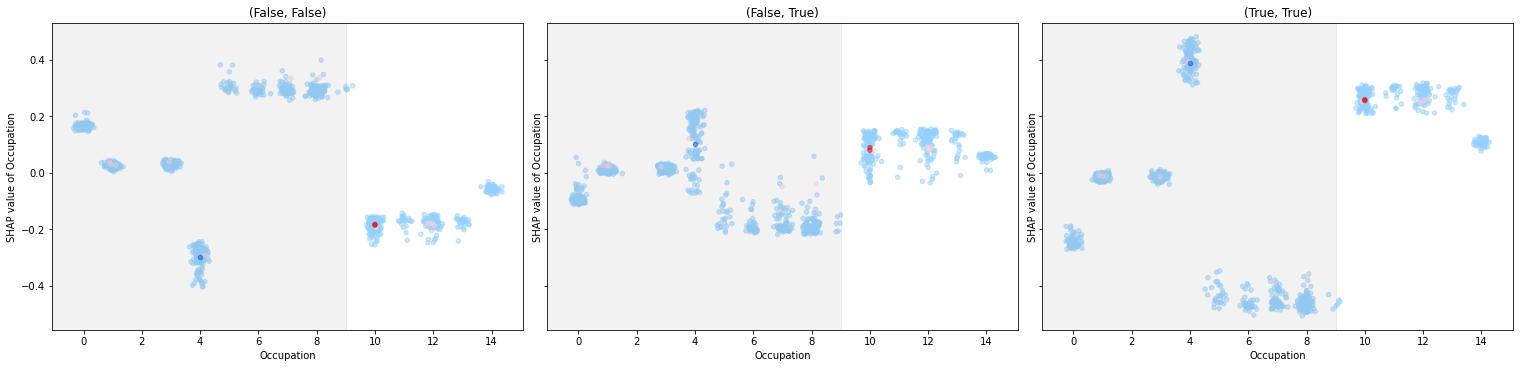

Hours per week == 40.0
Hours per week <= 39.0 --> {'(False, False)': 2}
Hours per week >= 42.0 --> {'(True, True)': 2}


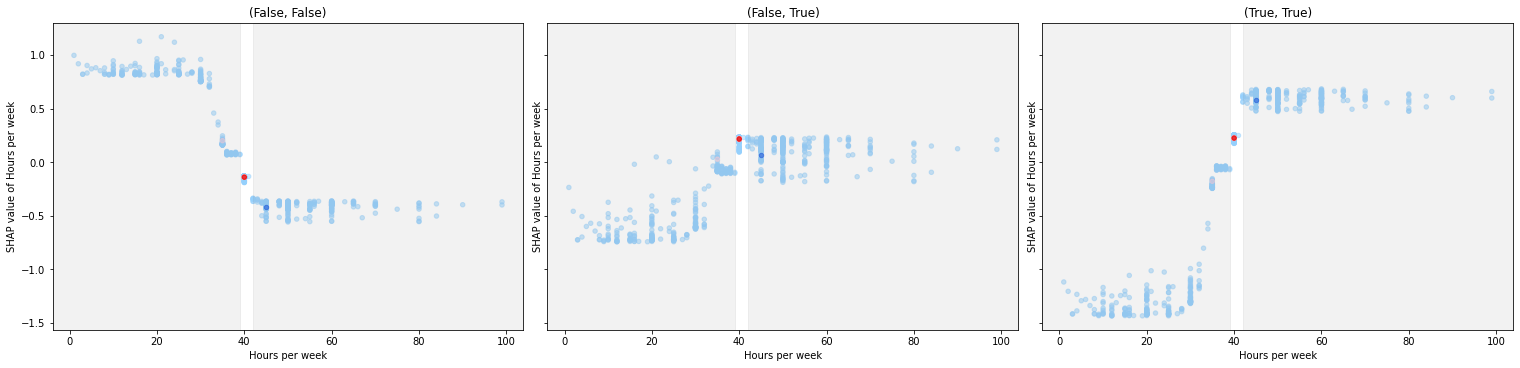

Capital Loss == 0.0
Capital Loss >= 1748.0 --> {'(True, True)': 2}


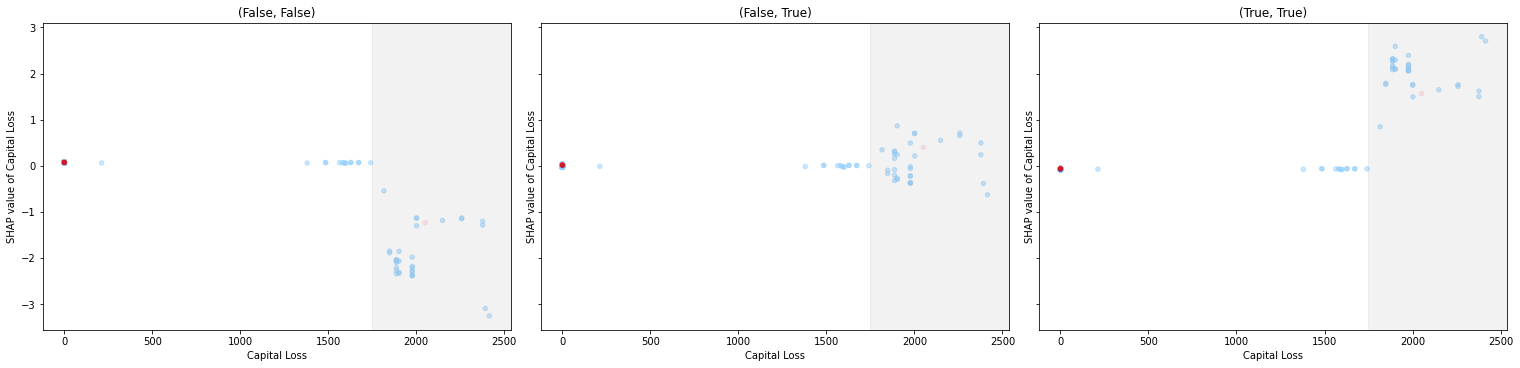

In [46]:
for feature in node.features_with_counterfactuals[:]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=ref_node, alpha=0.5)

### Node RRRRRLRRLL

In [47]:
node = node.root.get('RRRRRLR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRRRRLRRLL,
 (False, True)    2
 (True, True)     1
 dtype: int64,
 0.886690842252324)

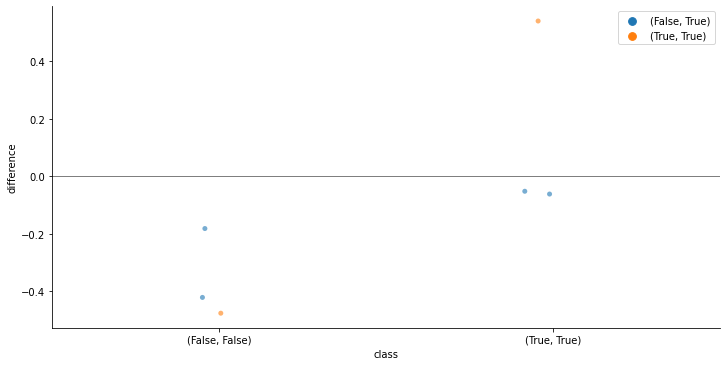

{'(False, False)': '-0.42 to -0.18', '(True, True)': '-0.06 to -0.05'}


In [48]:
ref_node = node
ref_node.plot_outcome_differences()

- Hours per week range where differences are likely is narrow (40-41), supported by the reference group which is very similar in terms of other features but has a higher Hours per week value (45)

In [49]:
ref_node.shap_values[:, 'Hours per week'].data

array([40., 35., 38.])

- Relationship: Difference is local to 5 (Wife), 4 (Husband) is already $(False, False)$ here
- Education-Num: Difference is local to 13
- Sex: both are 0 (Female), 1 would flip to $(True, True)$

Relationship == 5.0
Relationship <= 4.0 --> {'(False, False)': 2}


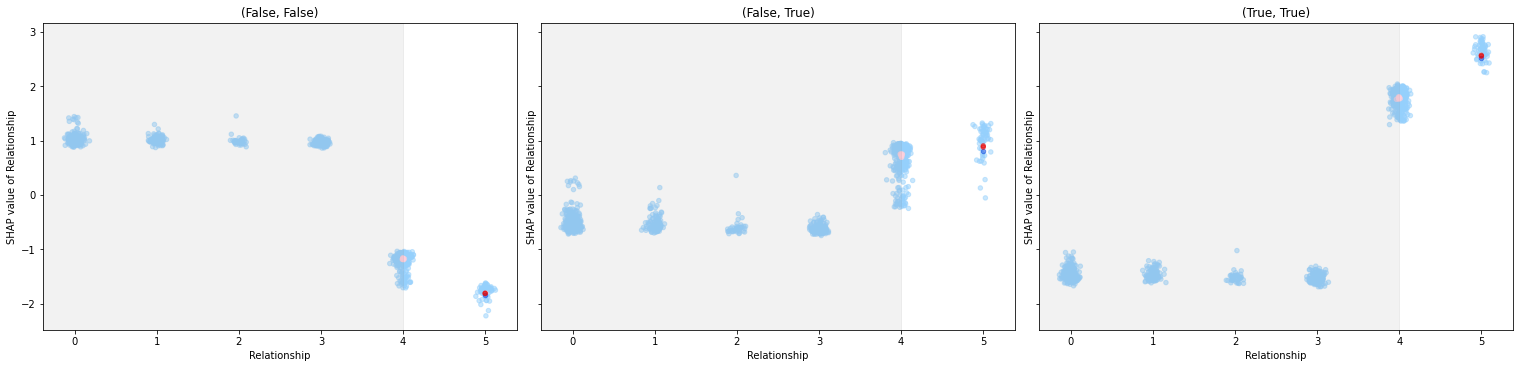

Education-Num == 13.0
Education-Num <= 12.0 --> {'(False, False)': 2}
Education-Num >= 14.0 --> {'(True, True)': 2}


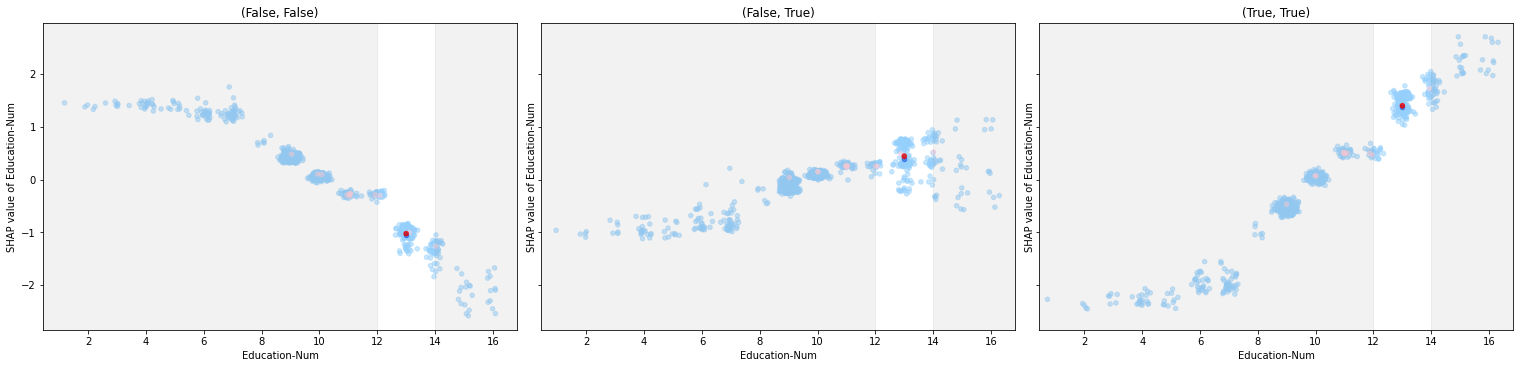

Capital Gain == 0.0
Capital Gain >= 4244.0 --> {'(True, True)': 2}


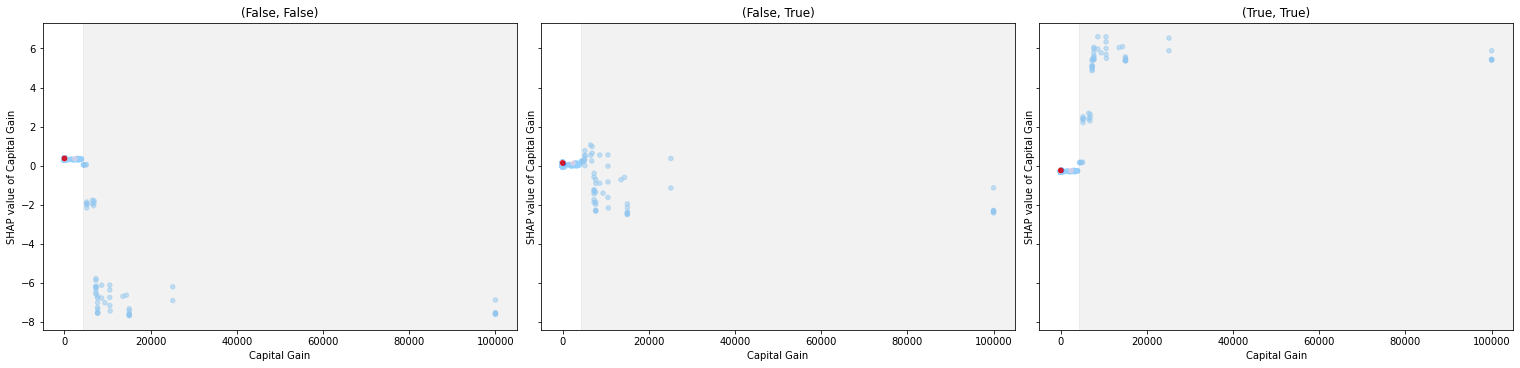

30.0 <= Age <= 32.0
Age <= 27.0 --> {'(False, False)': 2}
Age >= 34.0 --> {'(True, True)': 2}


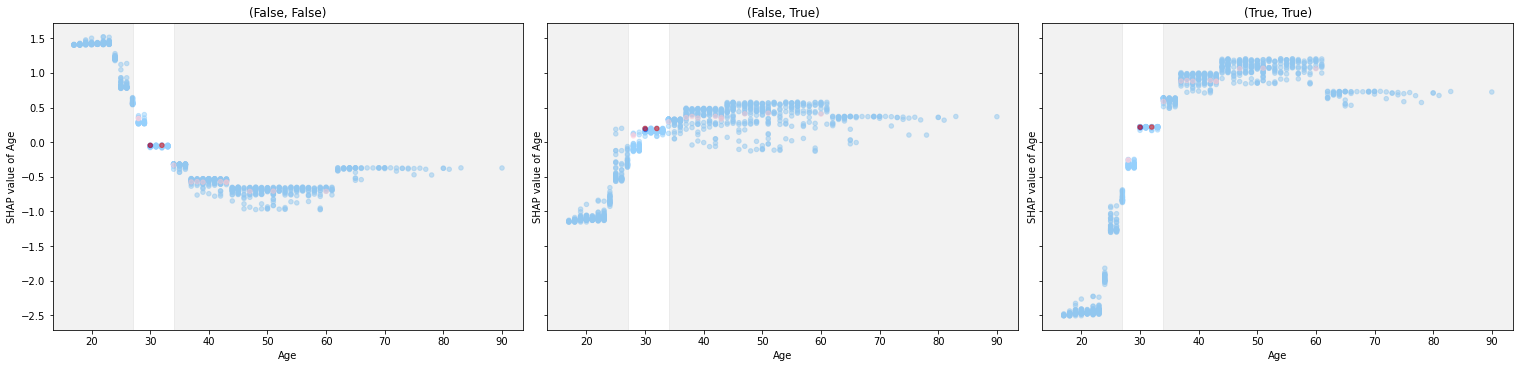

1.0 <= Occupation <= 8.0
Occupation >= 10.0 --> {'(True, True)': 2}


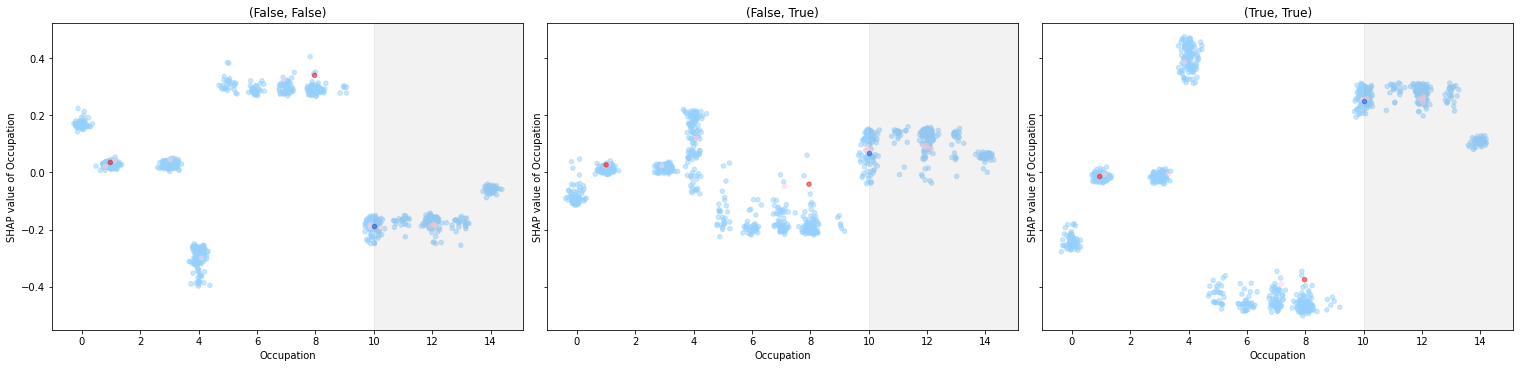

35.0 <= Hours per week <= 40.0
Hours per week <= 33.0 --> {'(False, False)': 2}
Hours per week >= 42.0 --> {'(True, True)': 2}


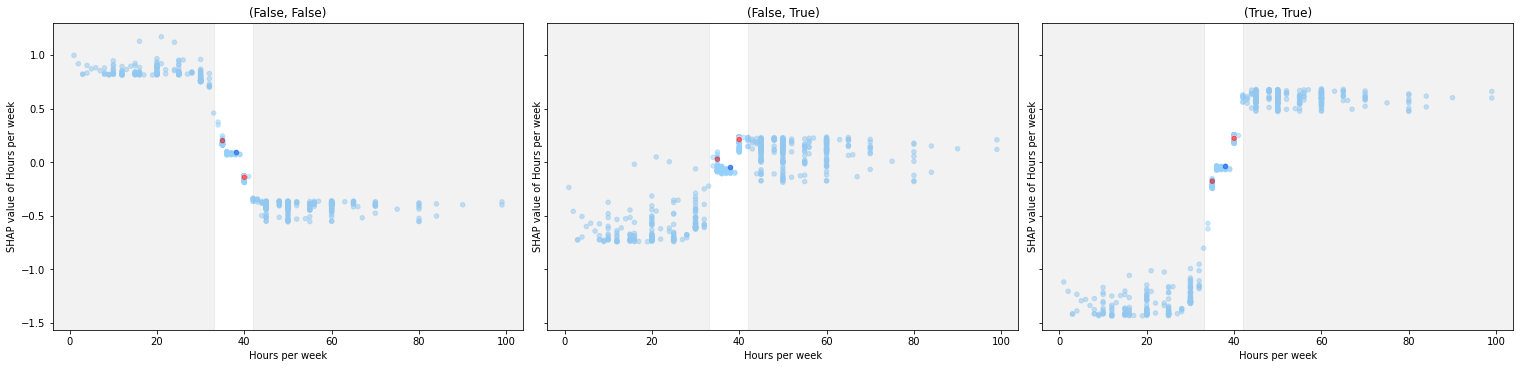

Sex == 0.0
Sex >= 1.0 --> {'(True, True)': 2}


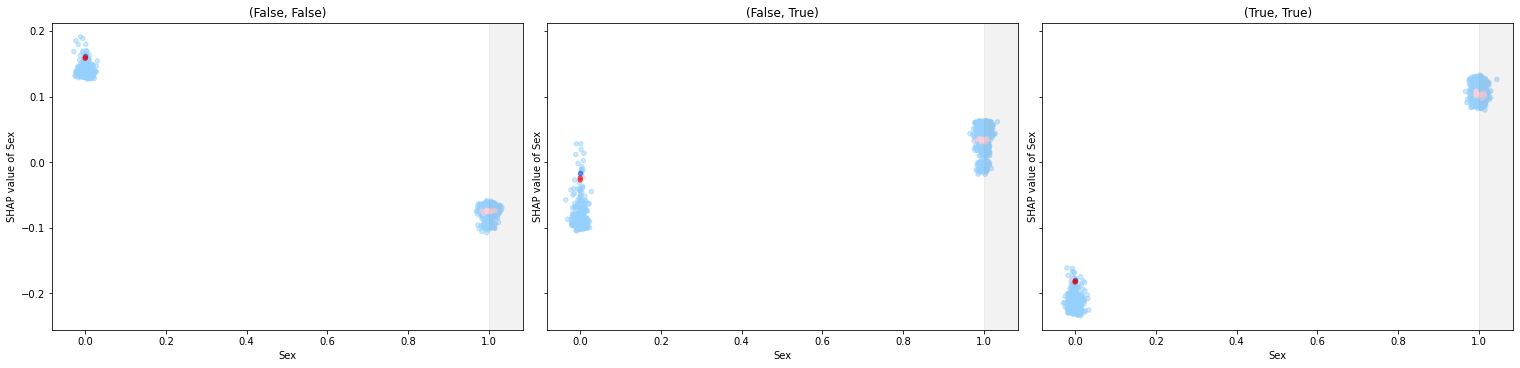

Capital Loss == 0.0
Capital Loss >= 1748.0 --> {'(True, True)': 2}


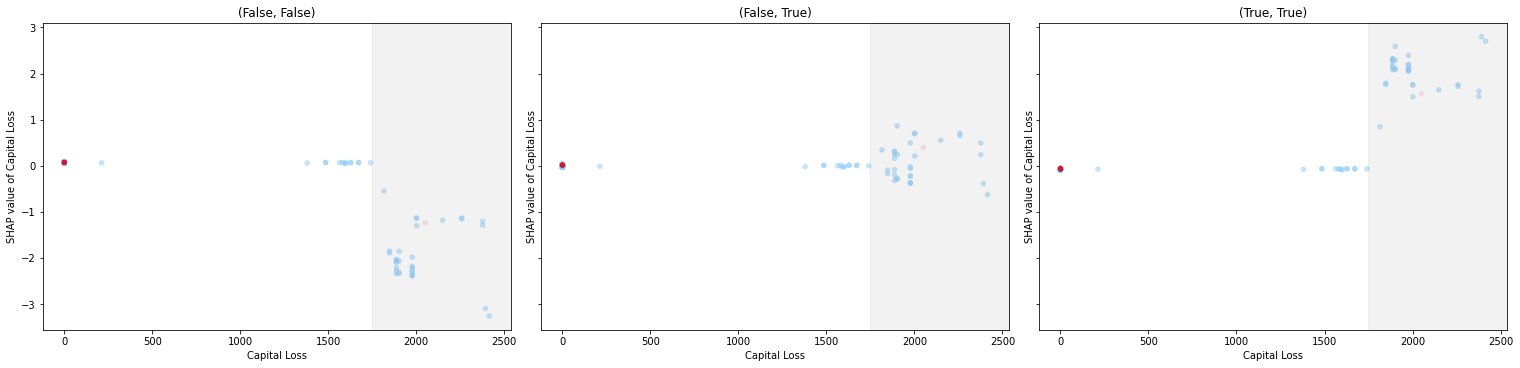

In [51]:
for feature in node.features_with_counterfactuals[:]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=ref_node, alpha=0.5)

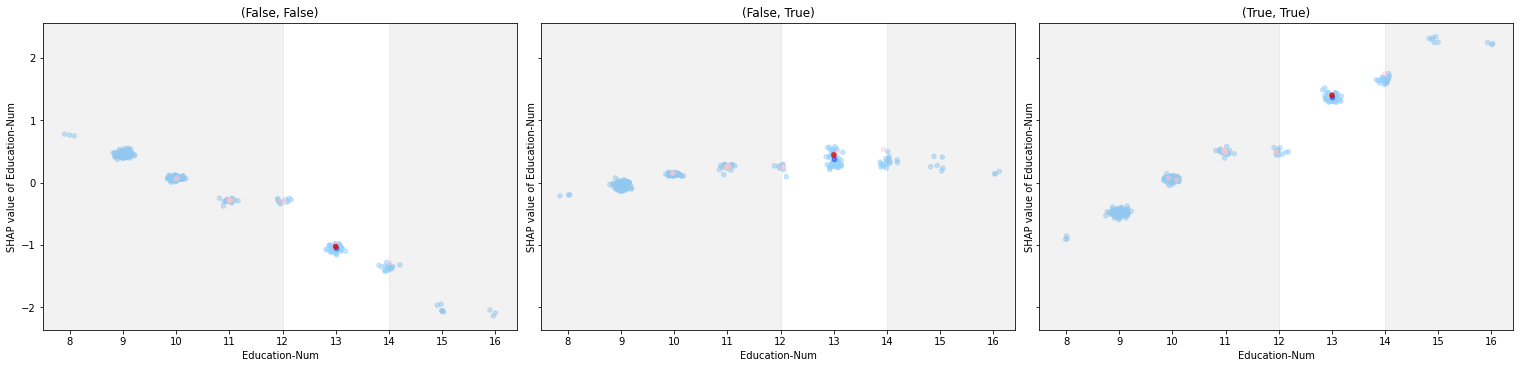

In [52]:
node.get_parent(6).plot_feature_dependence('Education-Num', focus=node, alpha=0.5)

Education-Num shows no clear dependence trend for the difference class above 12. But on a local level I see, that 13 is the peak here.

### Node RRRRRRRRR

In [53]:
node = node.root.get('RRRRRR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRRRRRRRR,
 (False, False)    117
 (True, True)       17
 (False, True)       9
 dtype: int64,
 5.367508744014738)

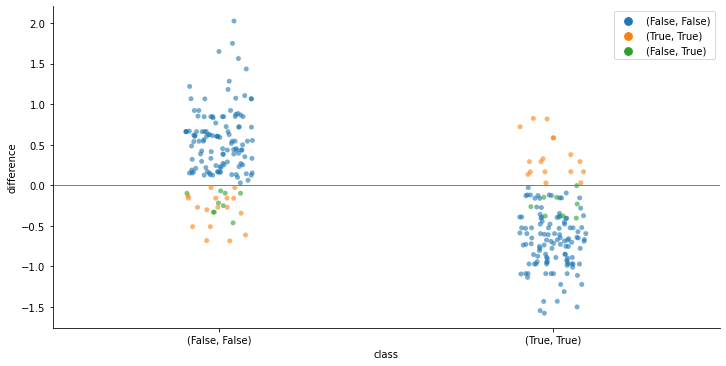

{'(False, False)': '-0.46 to -0.07', '(True, True)': '-0.41 to -0.0'}


In [54]:
ref_node = node
ref_node.plot_outcome_differences()

- Hours per week: difference is local to 40-41 for this group, despite of the other feature values being quite different

4.0 <= Relationship
Relationship <= 3.0 --> {'(False, False)': 9}


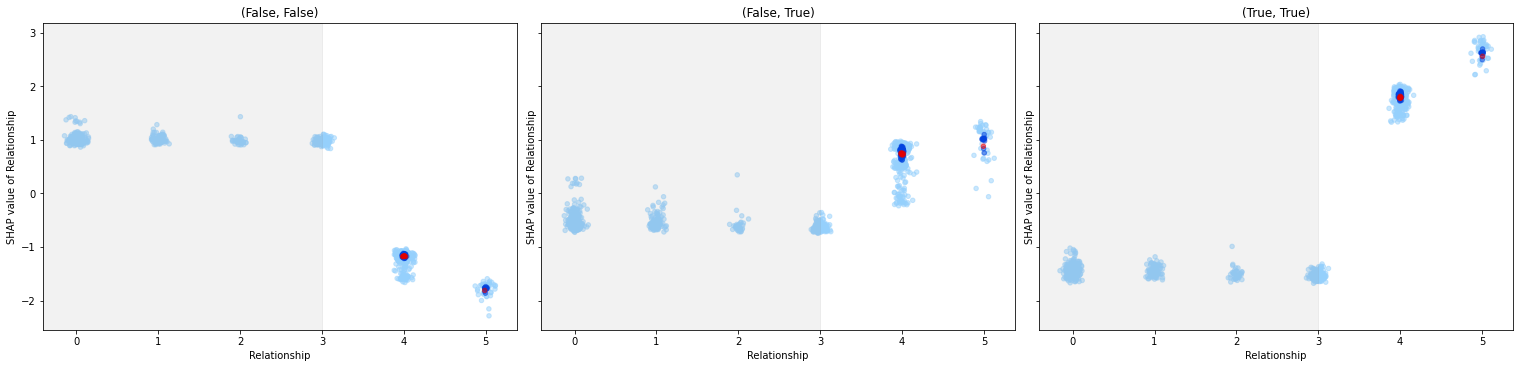

34.0 <= Age <= 60.0
Age <= 33.0 --> {'(False, False)': 9}


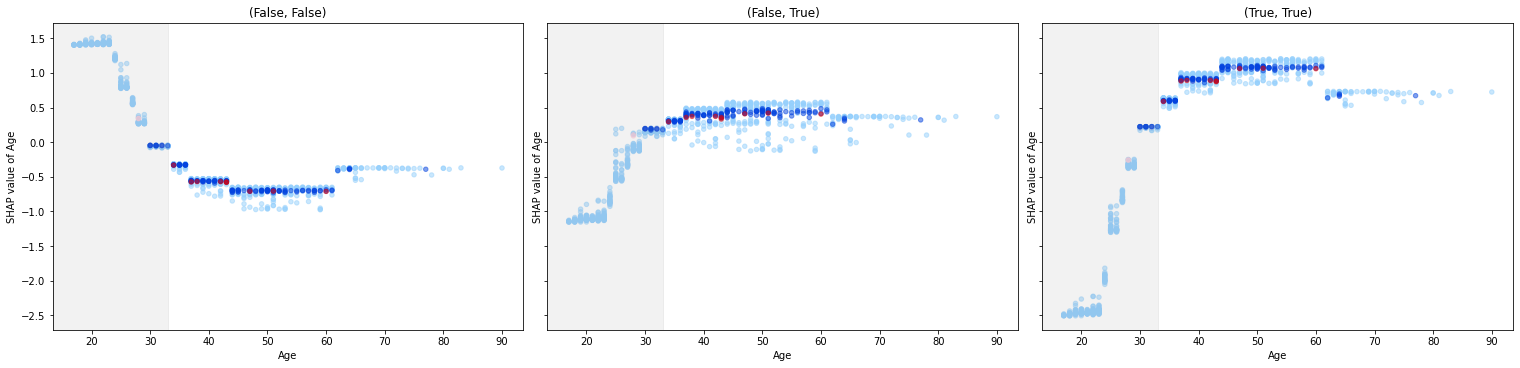

Hours per week == 40.0
Hours per week <= 39.0 --> {'(False, False)': 9}
Hours per week >= 42.0 --> {'(True, True)': 9}


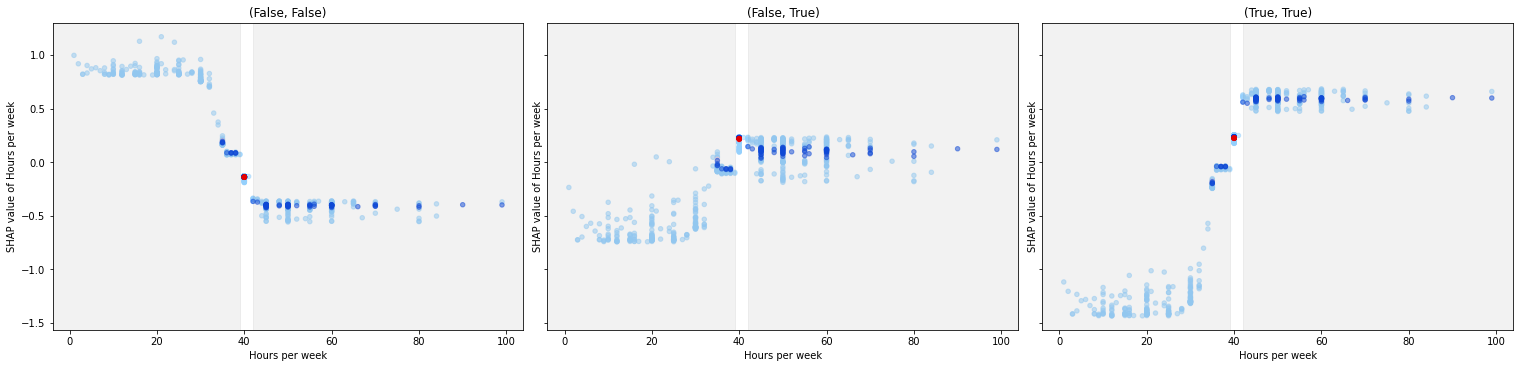

Capital Gain <= 2407.0
Capital Gain >= 5119.0 --> {'(True, True)': 9}


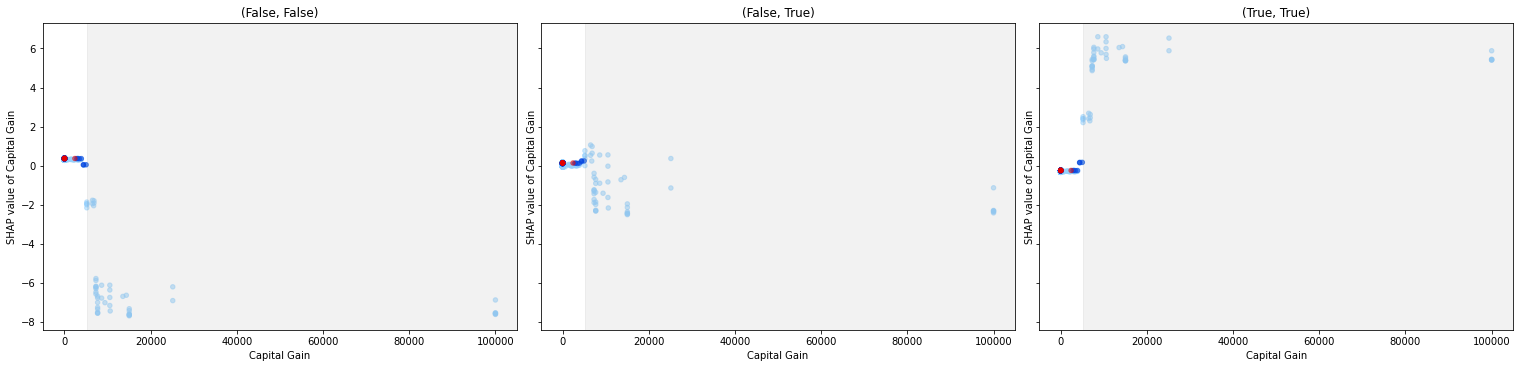

10.0 <= Education-Num <= 12.0
Education-Num <= 9.0 --> {'(False, False)': 9}
Education-Num >= 13.0 --> {'(True, True)': 9}


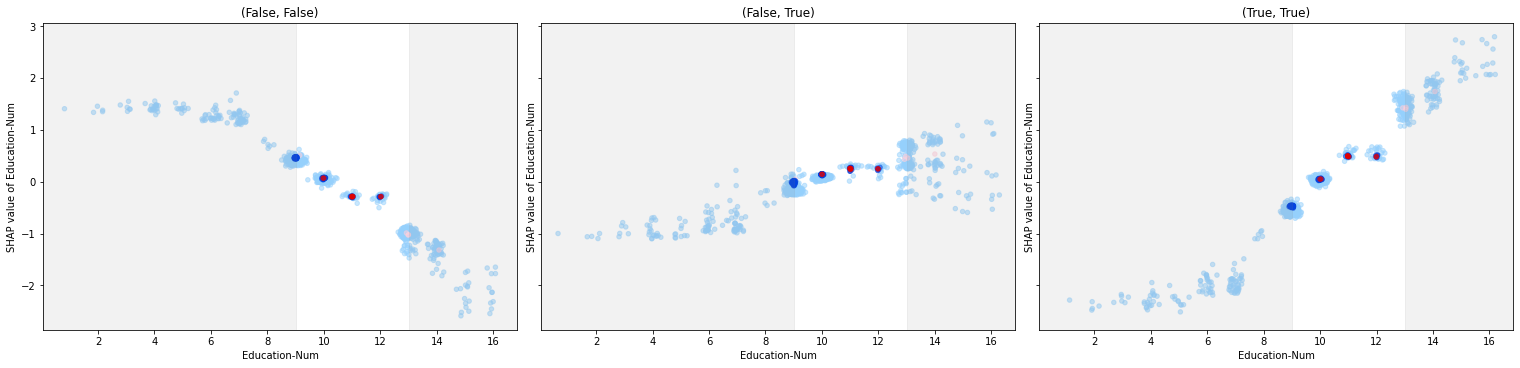

Capital Loss == 0.0
Capital Loss >= 1748.0 --> {'(True, True)': 9}


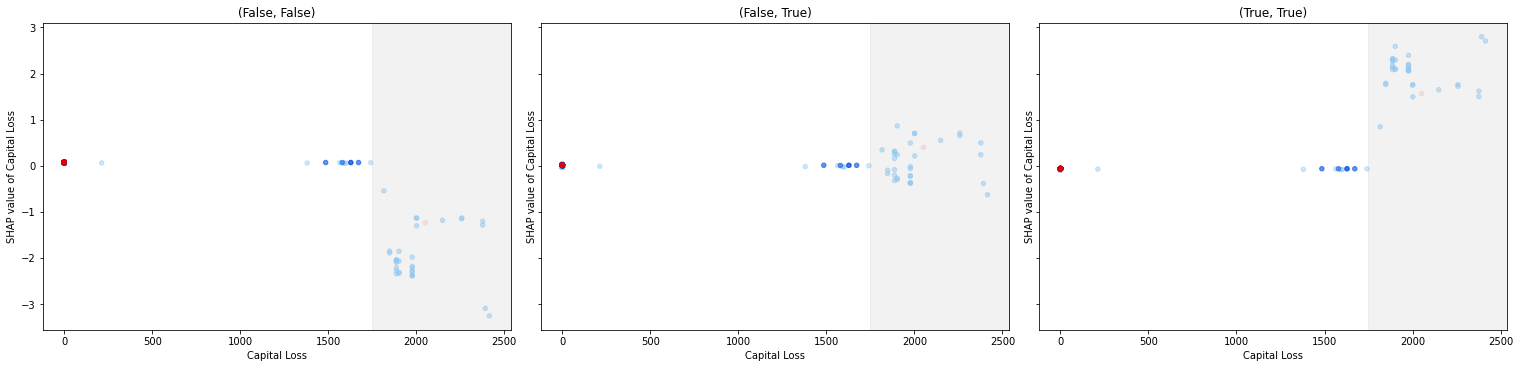

In [55]:
for feature in node.features_with_counterfactuals[:]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=ref_node, alpha=0.5)